# Trabajo de Fin de Grado: Estudio sobre la aplicación de aprendizaje automático en mercados financieros

**Por Julio Ballesteros**


# Notebook 1: Obtención y análisis de series temporales.

El objetivo de este notebook es obtener, procesar y analizar los datos de las series temporales que se van a utilizar en el estudio. Estos datos se componen de las series temporales que se intentarán predecir. En este notebook se prepara los datos para su uso en fases posteriores del estudio además de realizarse una exploración para descubrir propiedades de estas series temporales.

**Tabla de contenidos:**
    1. Obtención y limpieza de datos
        1.1. Obtención y descripción
        1.2. Limpieza de los datos obtenidos
    2. Exploración y análisis de los datos
        2.1. Obtención de los retornos
        2.2. Visualización de los datos
        2.3. Hechos estilizados
        2.4. Obtención y estudio variable alcista/bajista
        2.5. Obtención y estudio variable posición

### Notebook Setup

In [1]:
#Importar librerías
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

#Importar modulos
from scripts import data_preparation

In [2]:
# Python ≥3.7 necesario
assert sys.version_info >= (3, 7)

np.random.seed(222)

from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk')

# función para guardar los gráficos
PROJECT_ROOT_DIR = '.'
FIGS_FOLDER = 'figures'
FIGS_PATH = os.path.join(PROJECT_ROOT_DIR, FIGS_FOLDER)

def save_fig(name, figs_path=FIGS_PATH, subfolder=None, tight_layout=True, extension="png", resolution=300):
    fig_path = os.path.join(figs_path, subfolder) if subfolder else figs_path
    if not os.path.isdir(fig_path):
        os.makedirs(fig_path)
        
    path = os.path.join(fig_path, name + "." + extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=extension, dpi=resolution)

# 1. Obtención y limpieza de los datos

## 1.1. Obtención y descripción

In [3]:
# datos a descargar
asset = '^GSPC'
start_date='2000-01-01'
end_date='2021-04-01'

In [4]:
# obtención de datos
stock_prices = data_preparation.get_financial_data(asset, start_date=start_date, end_date=end_date)

# descripción general de datos obtenidos
display(stock_prices.info())
display(stock_prices.head())
display(stock_prices.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5346 entries, 1999-12-31 to 2021-03-31
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5346 non-null   float64
 1   High          5346 non-null   float64
 2   Low           5346 non-null   float64
 3   Close         5346 non-null   float64
 4   Volume        5346 non-null   int64  
 5   Dividends     5346 non-null   int64  
 6   Stock Splits  5346 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 334.1 KB


None

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-12-31,1464.47,1472.42,1458.19,1469.25,374050000,0,0
2000-01-03,1469.25,1478.00,1438.36,1455.22,931800000,0,0
2000-01-04,1455.22,1455.22,1397.43,1399.42,1009000000,0,0
2000-01-05,1399.42,1413.27,1377.68,1402.11,1085500000,0,0
2000-01-06,1402.11,1411.90,1392.10,1403.45,1092300000,0,0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-03-25,3879.34,3919.54,3853.50,3909.52,4940800000,0,0
2021-03-26,3917.12,3978.19,3917.12,3974.54,5467850000,0,0
2021-03-29,3969.31,3981.83,3943.25,3971.09,4619840000,0,0
2021-03-30,3963.34,3968.01,3944.35,3958.55,4103570000,0,0
2021-03-31,3967.25,3994.41,3966.98,3972.89,4564980000,0,0


## 1.2. Limpieza de los datos obtenidos

In [5]:
# limpiar datos
stock_prices = data_preparation.clean_data(stock_prices)
display(stock_prices.head())

# comprobar si hay nan
print('NaN values:', np.any(stock_prices.isnull()))

,open,high,low,close,volume
Date,,,,,
1999-12-31,1464.47,1472.42,1458.19,1469.25,374050000
2000-01-03,1469.25,1478.00,1438.36,1455.22,931800000
2000-01-04,1455.22,1455.22,1397.43,1399.42,1009000000
2000-01-05,1399.42,1413.27,1377.68,1402.11,1085500000
2000-01-06,1402.11,1411.90,1392.10,1403.45,1092300000


NaN values: False


# 2. Exploración y análisis de los datos

## 2.1. Obtención de los retornos

In [6]:
# repetir la obtención de datos de la fase anterior si se empieza directamente
stock_prices = data_preparation.get_stock_prices('^GSPC', start_date='2000-01-01', end_date='2021-04-01')

In [7]:
#Creamos la variable de variación de precio (returns) para que sea estacionario (close no lo es)
stock_prices['returns'] = data_preparation.get_returns(stock_prices.close)

#eliminamos outliers
stock_prices = data_preparation.drop_outliers(stock_prices)

#eliminar los valores nan que quedan
stock_prices = stock_prices.dropna()

# Examinar los retornos
print('---- Estadísticas Descriptivas de los Retornos ----')
print('Rango de fechas:', min(stock_prices.index.date), '-', max(stock_prices.index.date))
print('Número de observaciones:', stock_prices.shape[0])
print(f'Media: {stock_prices.returns.mean():.4f}%')
print(f'Mediana: {stock_prices.returns.median():.4f}%')
print(f'Mínimo: {stock_prices.returns.min():.4f}%')
print(f'Máximo: {stock_prices.returns.max():.4f}%')
print(f'Desviación Estándar: {stock_prices.returns.std():.4f}%')

---- Estadísticas Descriptivas de los Retornos ----
Rango de fechas: 2000-01-03 - 2021-03-31
Número de observaciones: 5328
Media: 0.0347%
Mediana: 0.0617%
Mínimo: -11.9841%
Máximo: 11.5800%
Desviación Estándar: 1.2357%


## 2.2. Visualización de los datos

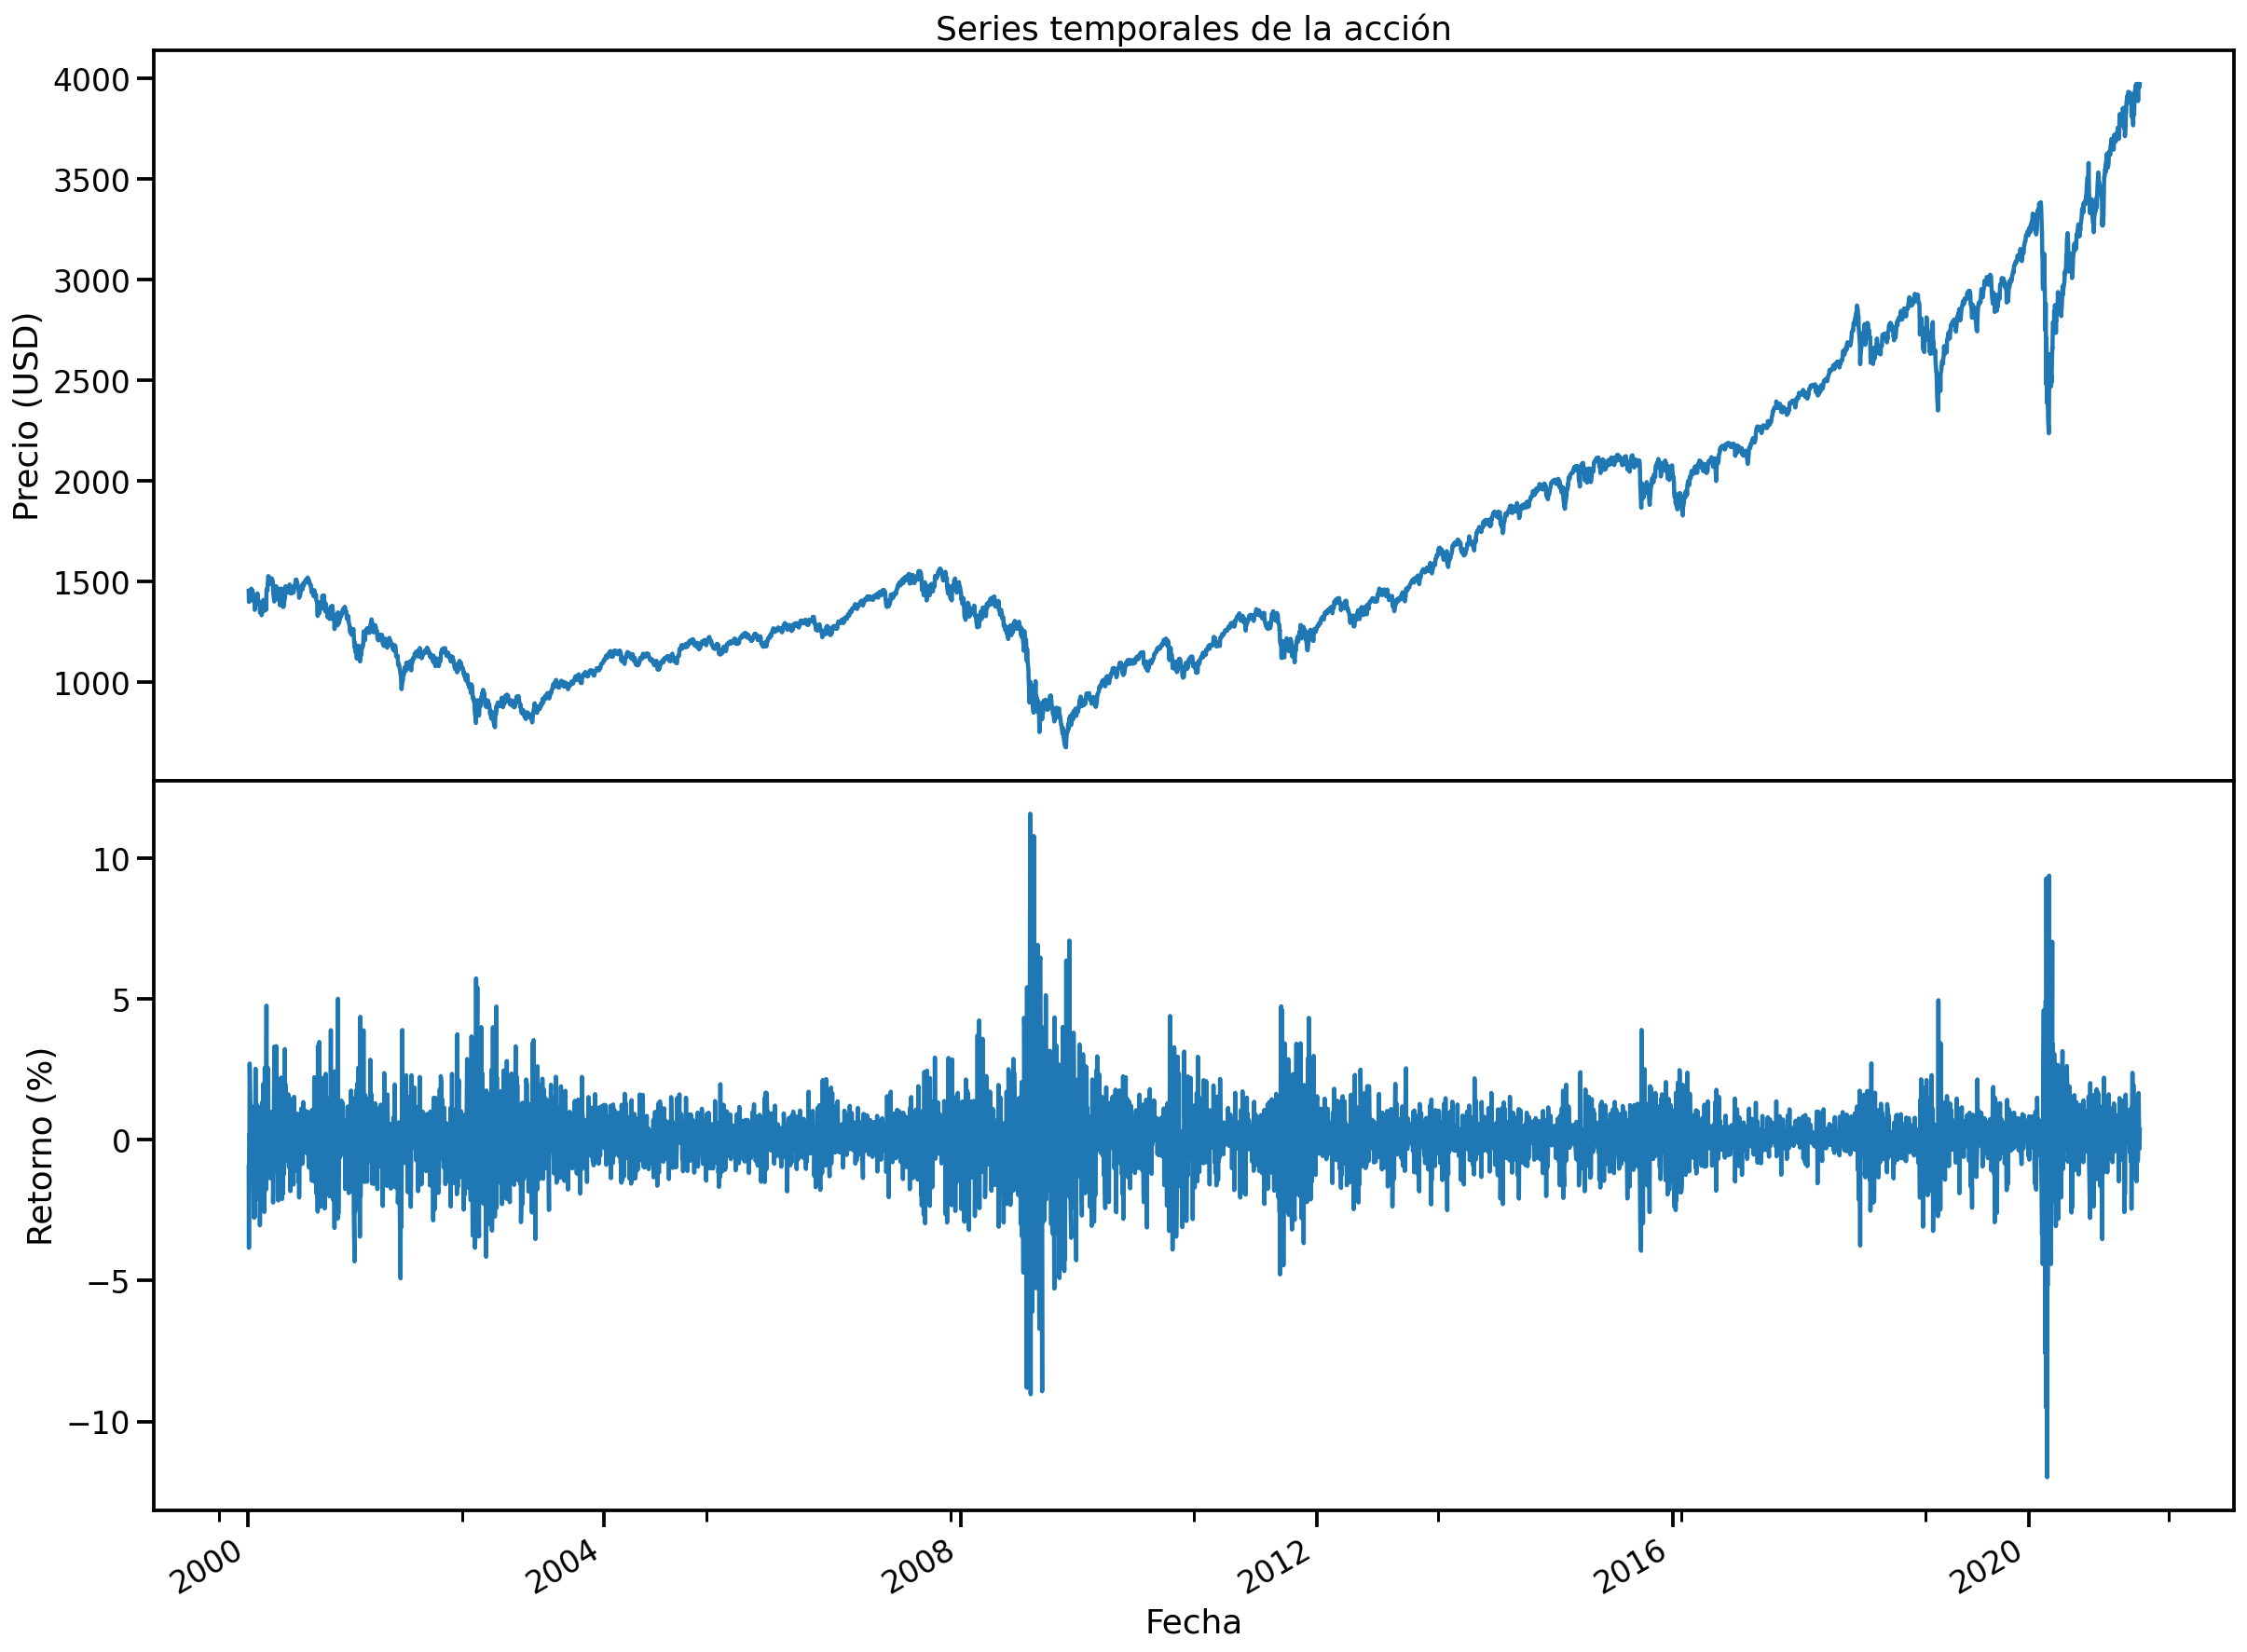

In [8]:
# Visualizar los datos que tenemos hasta ahora
fig, ax = plt.subplots(2, 1, figsize=(20, 16), sharex=True)

#plot del valor de cierre
stock_prices.close.plot(ax=ax[0])
ax[0].set_title('Series temporales de la acción')
ax[0].set(ylabel='Precio (USD)')

#plot de los retornos
(stock_prices.returns).plot(ax=ax[1])
ax[1].set(ylabel='Retorno (%)', xlabel='Fecha')

plt.subplots_adjust(hspace = 0)
save_fig('figure_1_1', tight_layout=False)
plt.show()

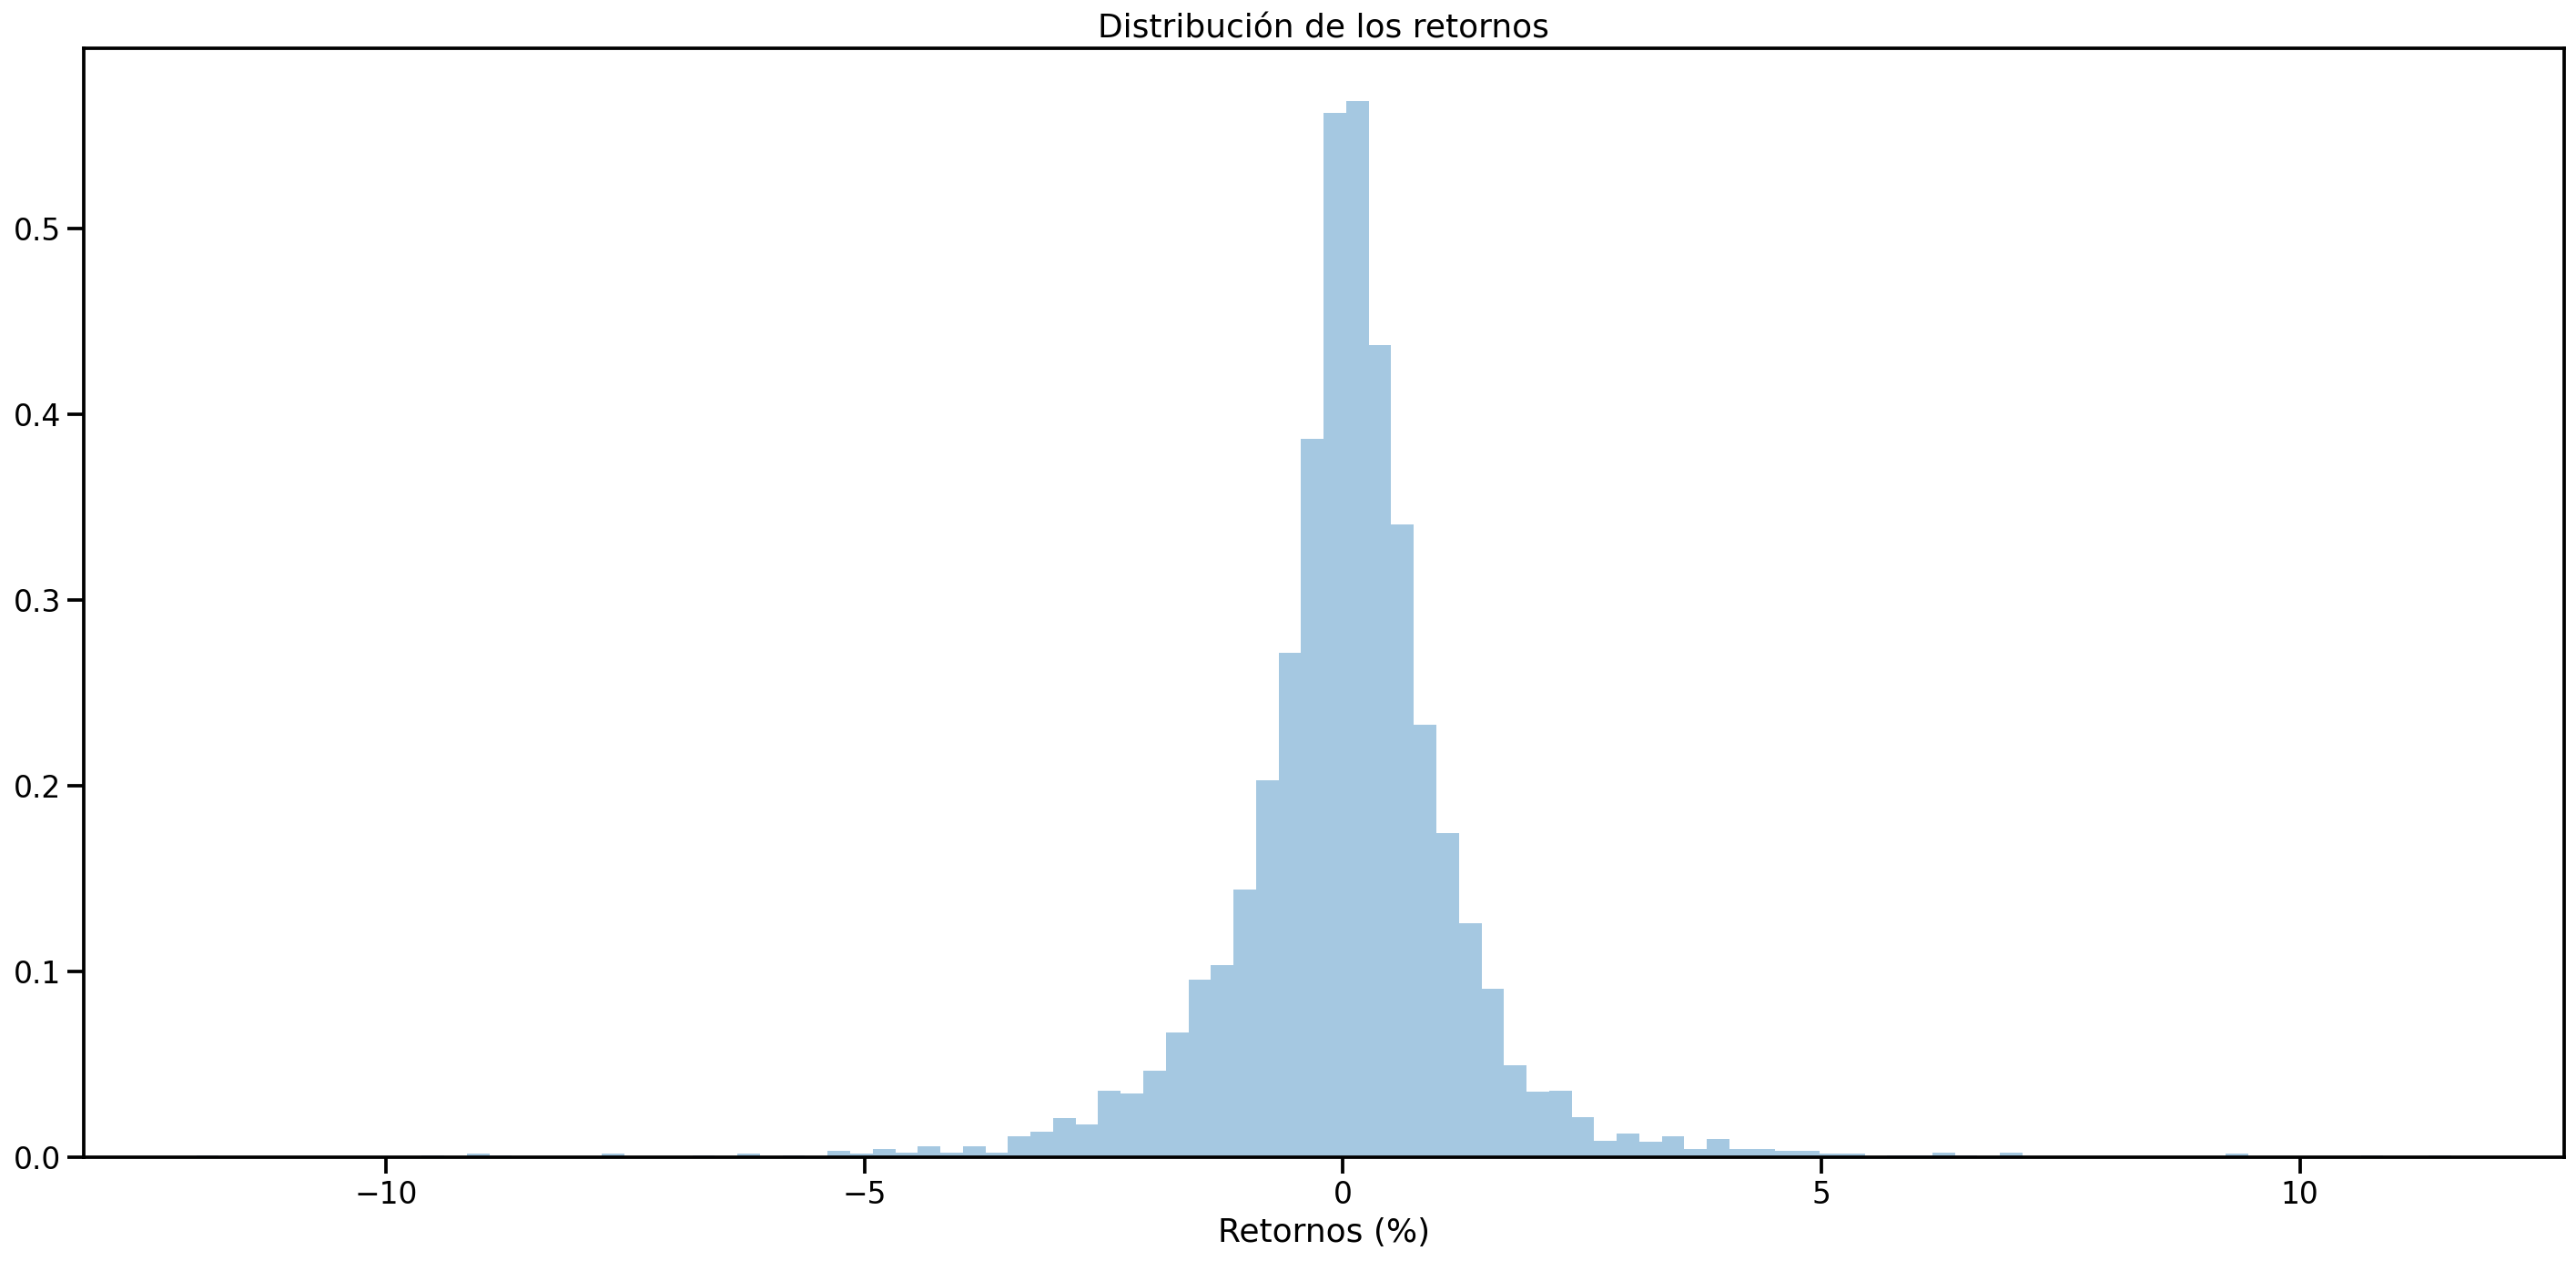

In [9]:
#plot de la distribucion de los retornos
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(stock_prices.returns, norm_hist=True, kde=False, bins=100, ax=ax)
plt.title('Distribución de los retornos')
plt.xlabel('Retornos (%)')

save_fig('figure_1_2')
plt.show()

## 2.3. Hechos estilizados

### Hecho #1: Distribución no gaussiana

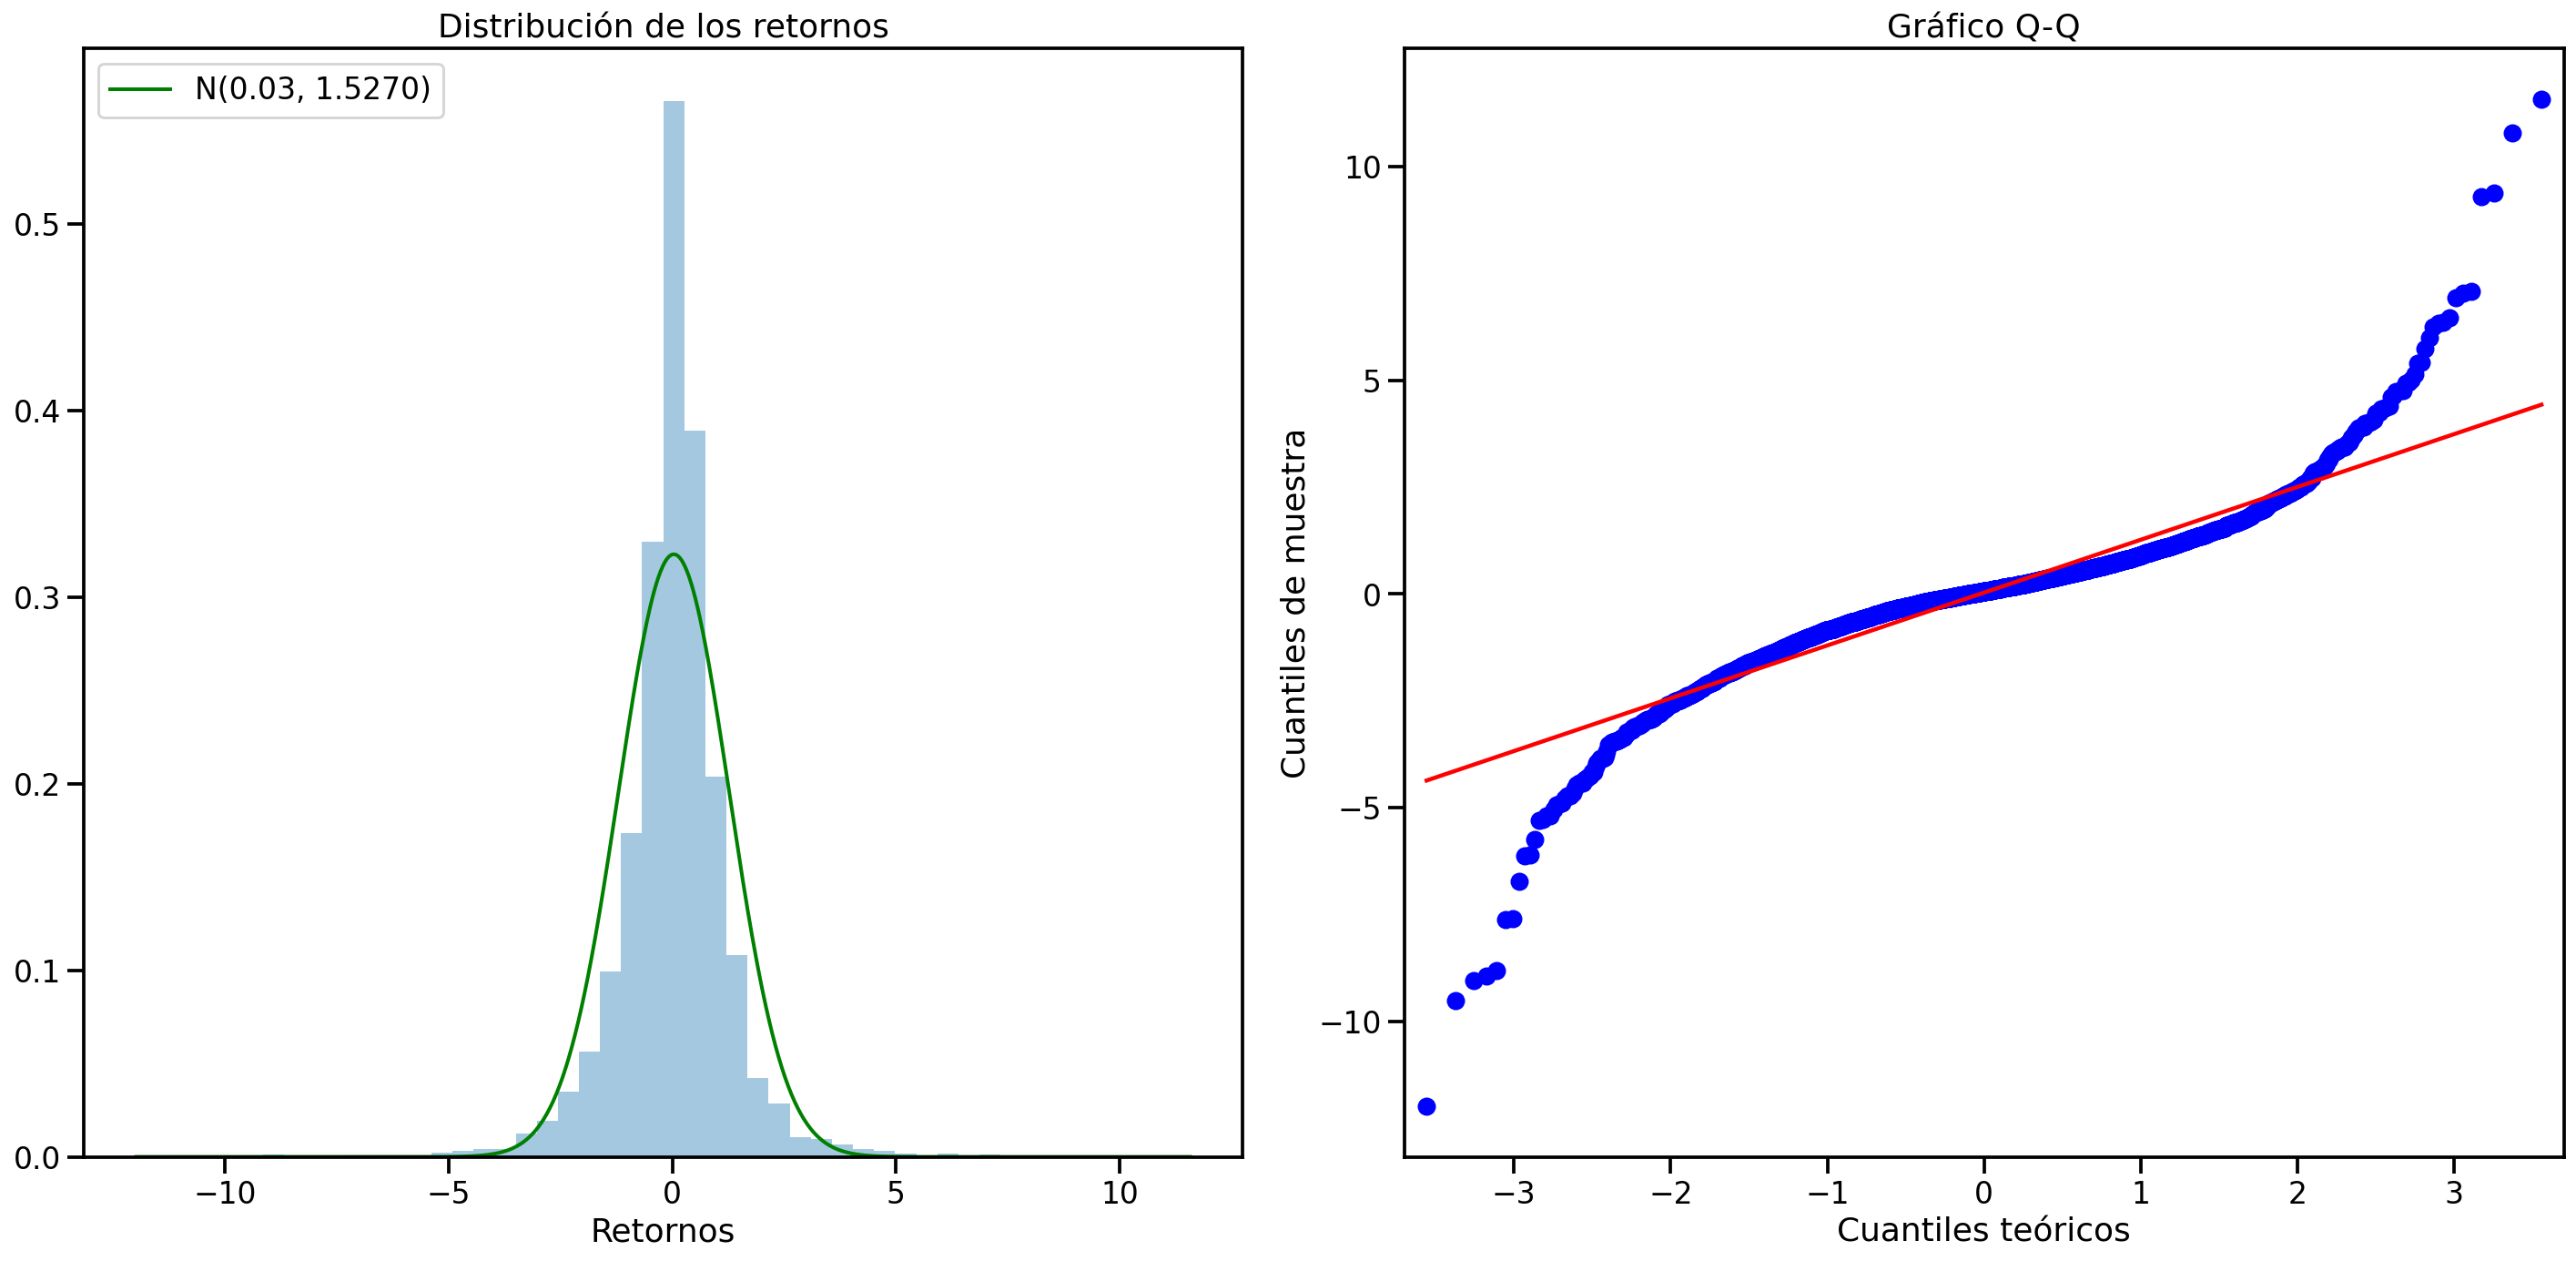

---------- Estadísticas de la distribución ----------
Oblicuidad: -0.0823
Curtosis: 10.9772
Estadístico Jarque-Bera: 26701.13 con valor p: 0.00


In [10]:
# crear pdf de distribucion normal
r_range = np.linspace(min(stock_prices.returns), max(stock_prices.returns), num=1000)
mu = stock_prices.returns.mean()
sigma = stock_prices.returns.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

#plot del histograma
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.distplot(stock_prices.returns, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribución de los retornos')
ax[0].set_xlabel('Retornos')
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left')

#Q-Q plot
qq = sm.qqplot(stock_prices.returns.values, line='s', ax=ax[1])
ax[1].set_title('Gráfico Q-Q')
ax[1].set_ylabel('Cuantiles de muestra')
ax[1].set_xlabel('Cuantiles teóricos')

save_fig('figure_1_3')
plt.show()

# estadísticas de la distribución
jb_test = scs.jarque_bera(stock_prices.returns.values)

print('---------- Estadísticas de la distribución ----------')
print(f'Oblicuidad: {stock_prices.returns.skew():.4f}')
print(f'Curtosis: {stock_prices.returns.kurtosis():.4f}') 
print(f'Estadístico Jarque-Bera: {jb_test[0]:.2f} con valor p: {jb_test[1]:.2f}')

### Hecho #2: Clustering de volatilidad

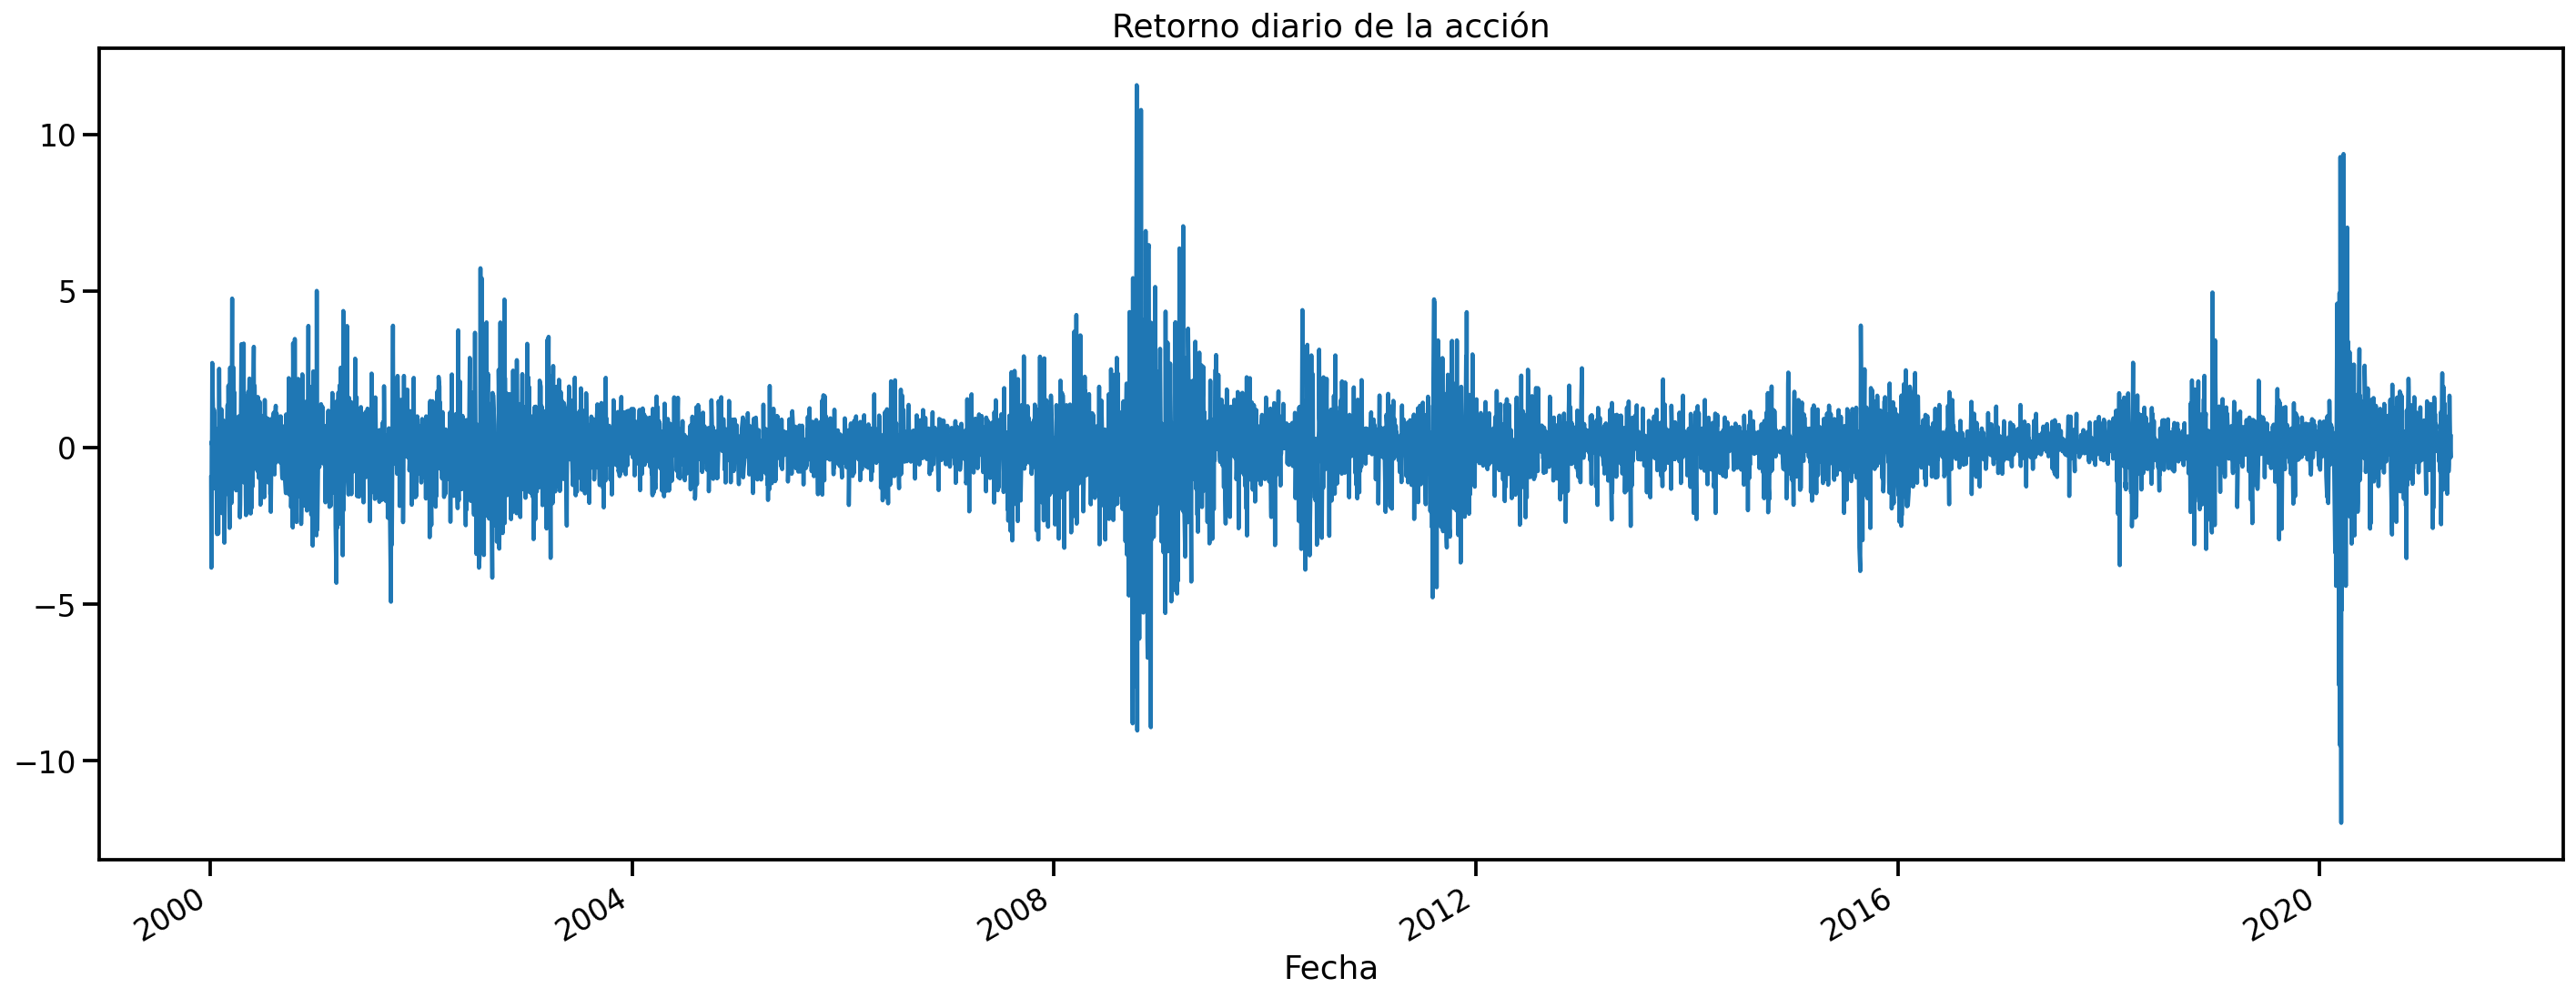

In [11]:
# plot de la serie temporal de retornos
fig, ax = plt.subplots(figsize=(20, 8))
stock_prices.returns.plot(title='Retorno diario de la acción', ax=ax)
plt.title('Retorno diario de la acción')
plt.xlabel('Fecha')

save_fig('figure_1_4')
plt.show()

### Hecho #3: Ausencia de correlación en los retornos

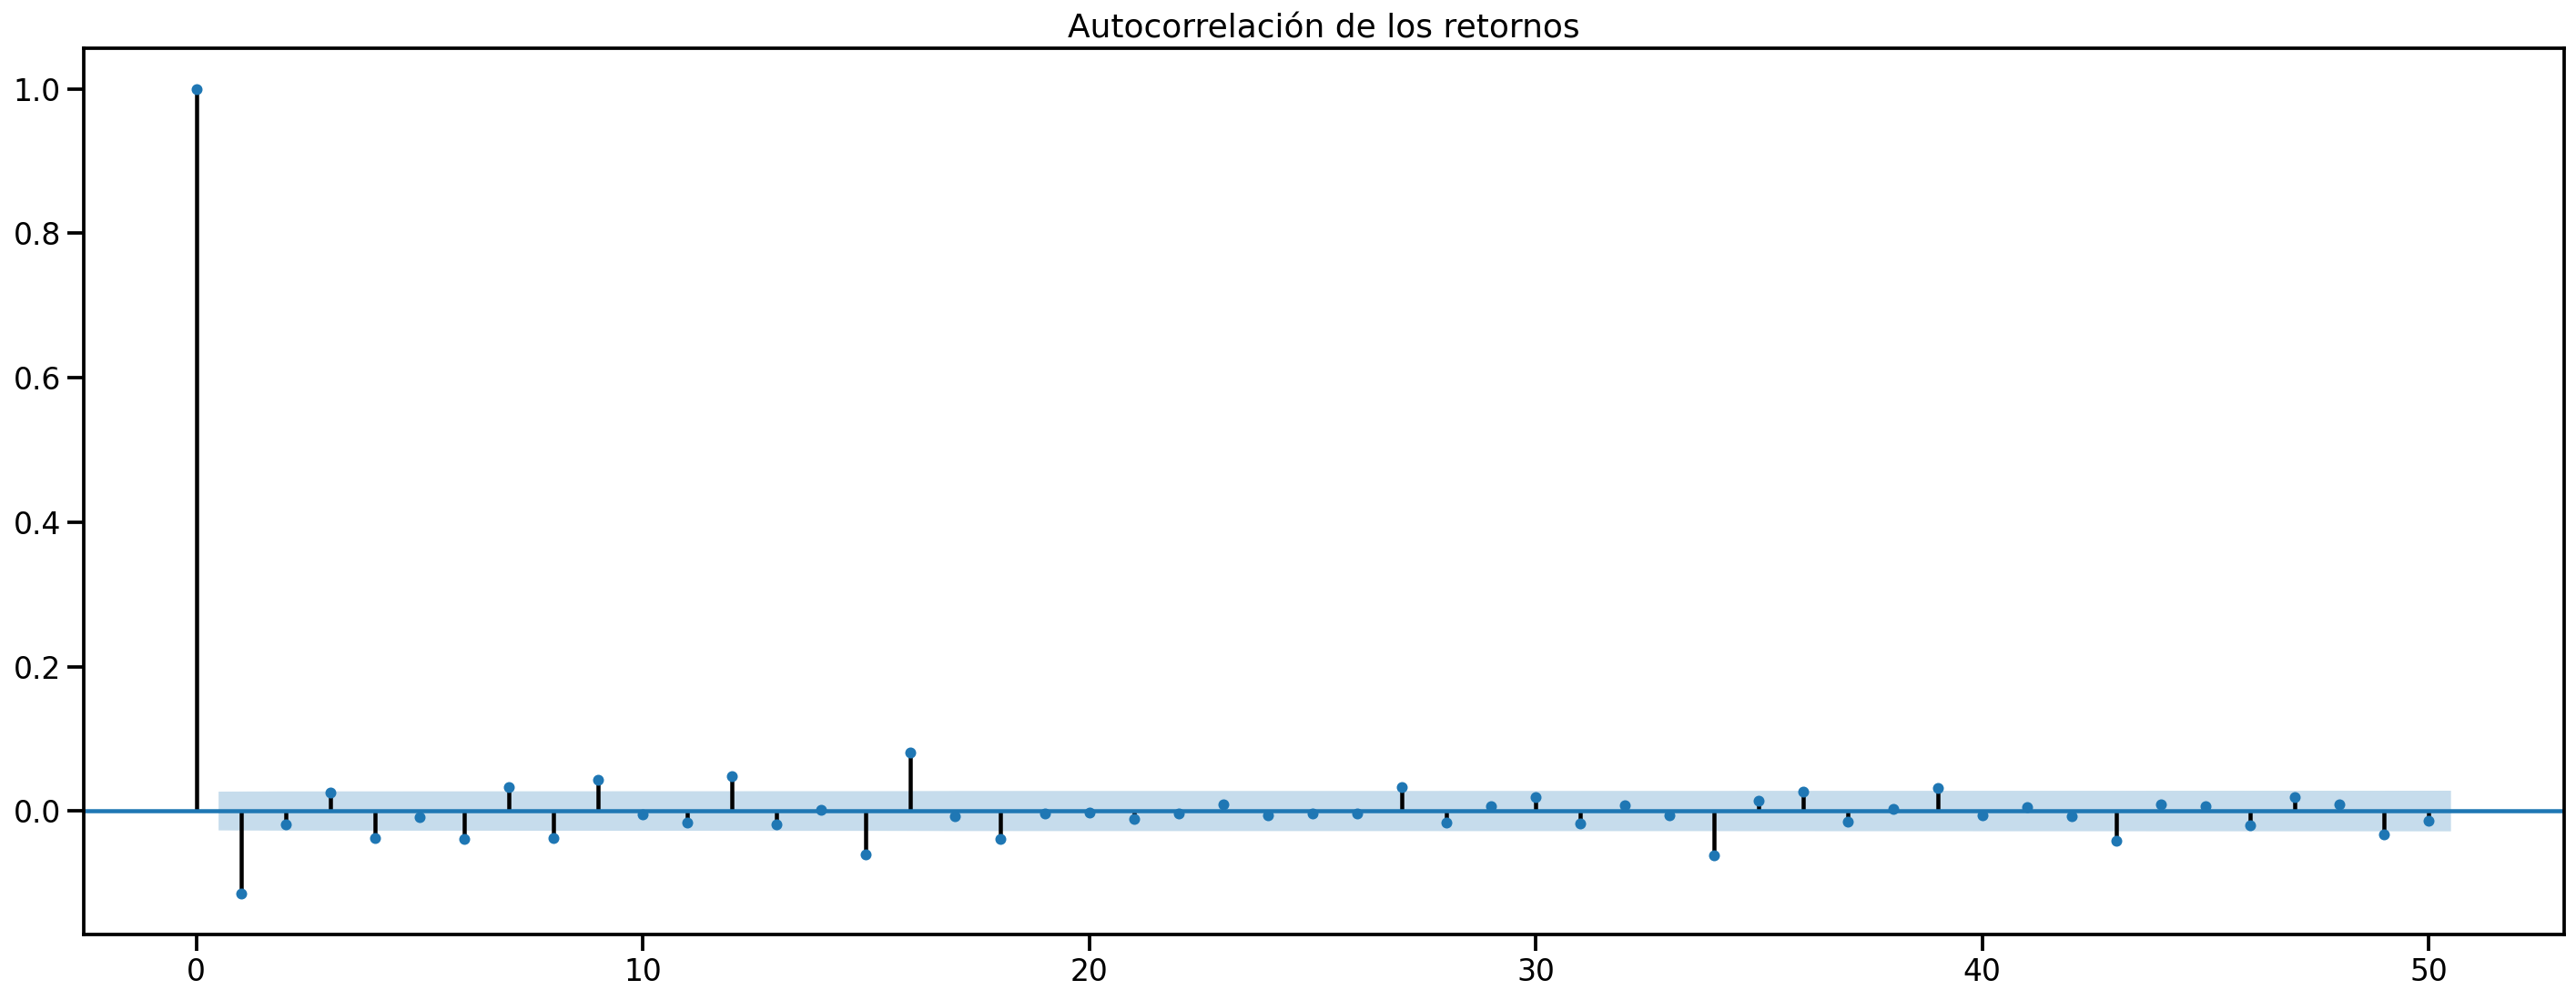

In [12]:
# plot de correlación de los retornos
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(figsize=(20, 8))
acf = smt.graphics.plot_acf(stock_prices.returns, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax)
plt.title('Autocorrelación de los retornos')

save_fig('figure_1_5')
plt.show()

### Hecho #4: Autocorrelación pequeña y decreciente en los retornos absolutos

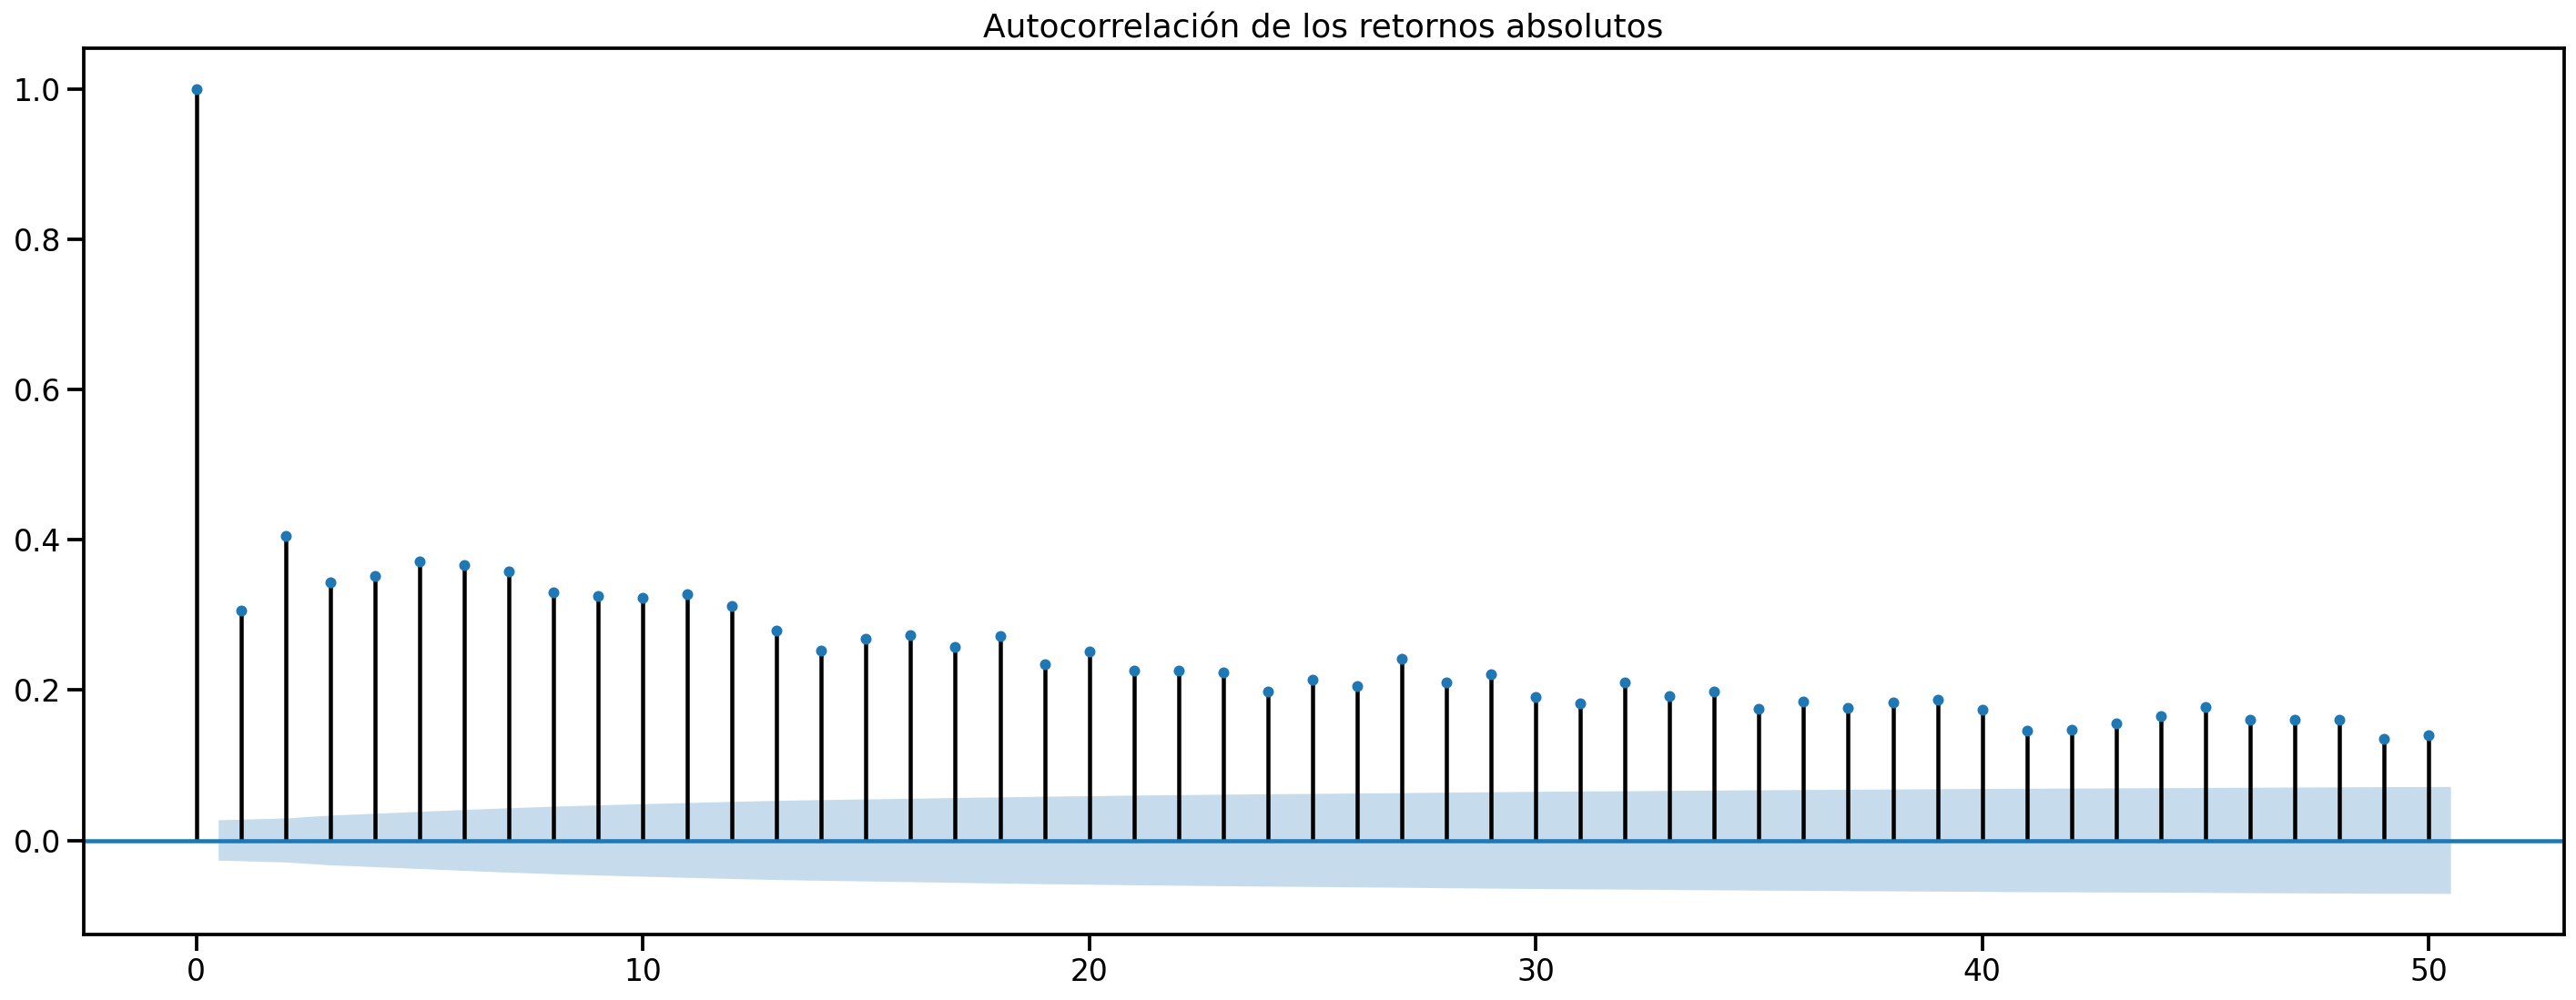

In [13]:
# plot de correlación de los retornos
fig, ax = plt.subplots(figsize=(20, 8))
acf = smt.graphics.plot_acf(np.abs(stock_prices.returns), lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax)
plt.title('Autocorrelación de los retornos absolutos')

save_fig('figure_1_6')
plt.show()

### Hecho #5: Apalancamiento

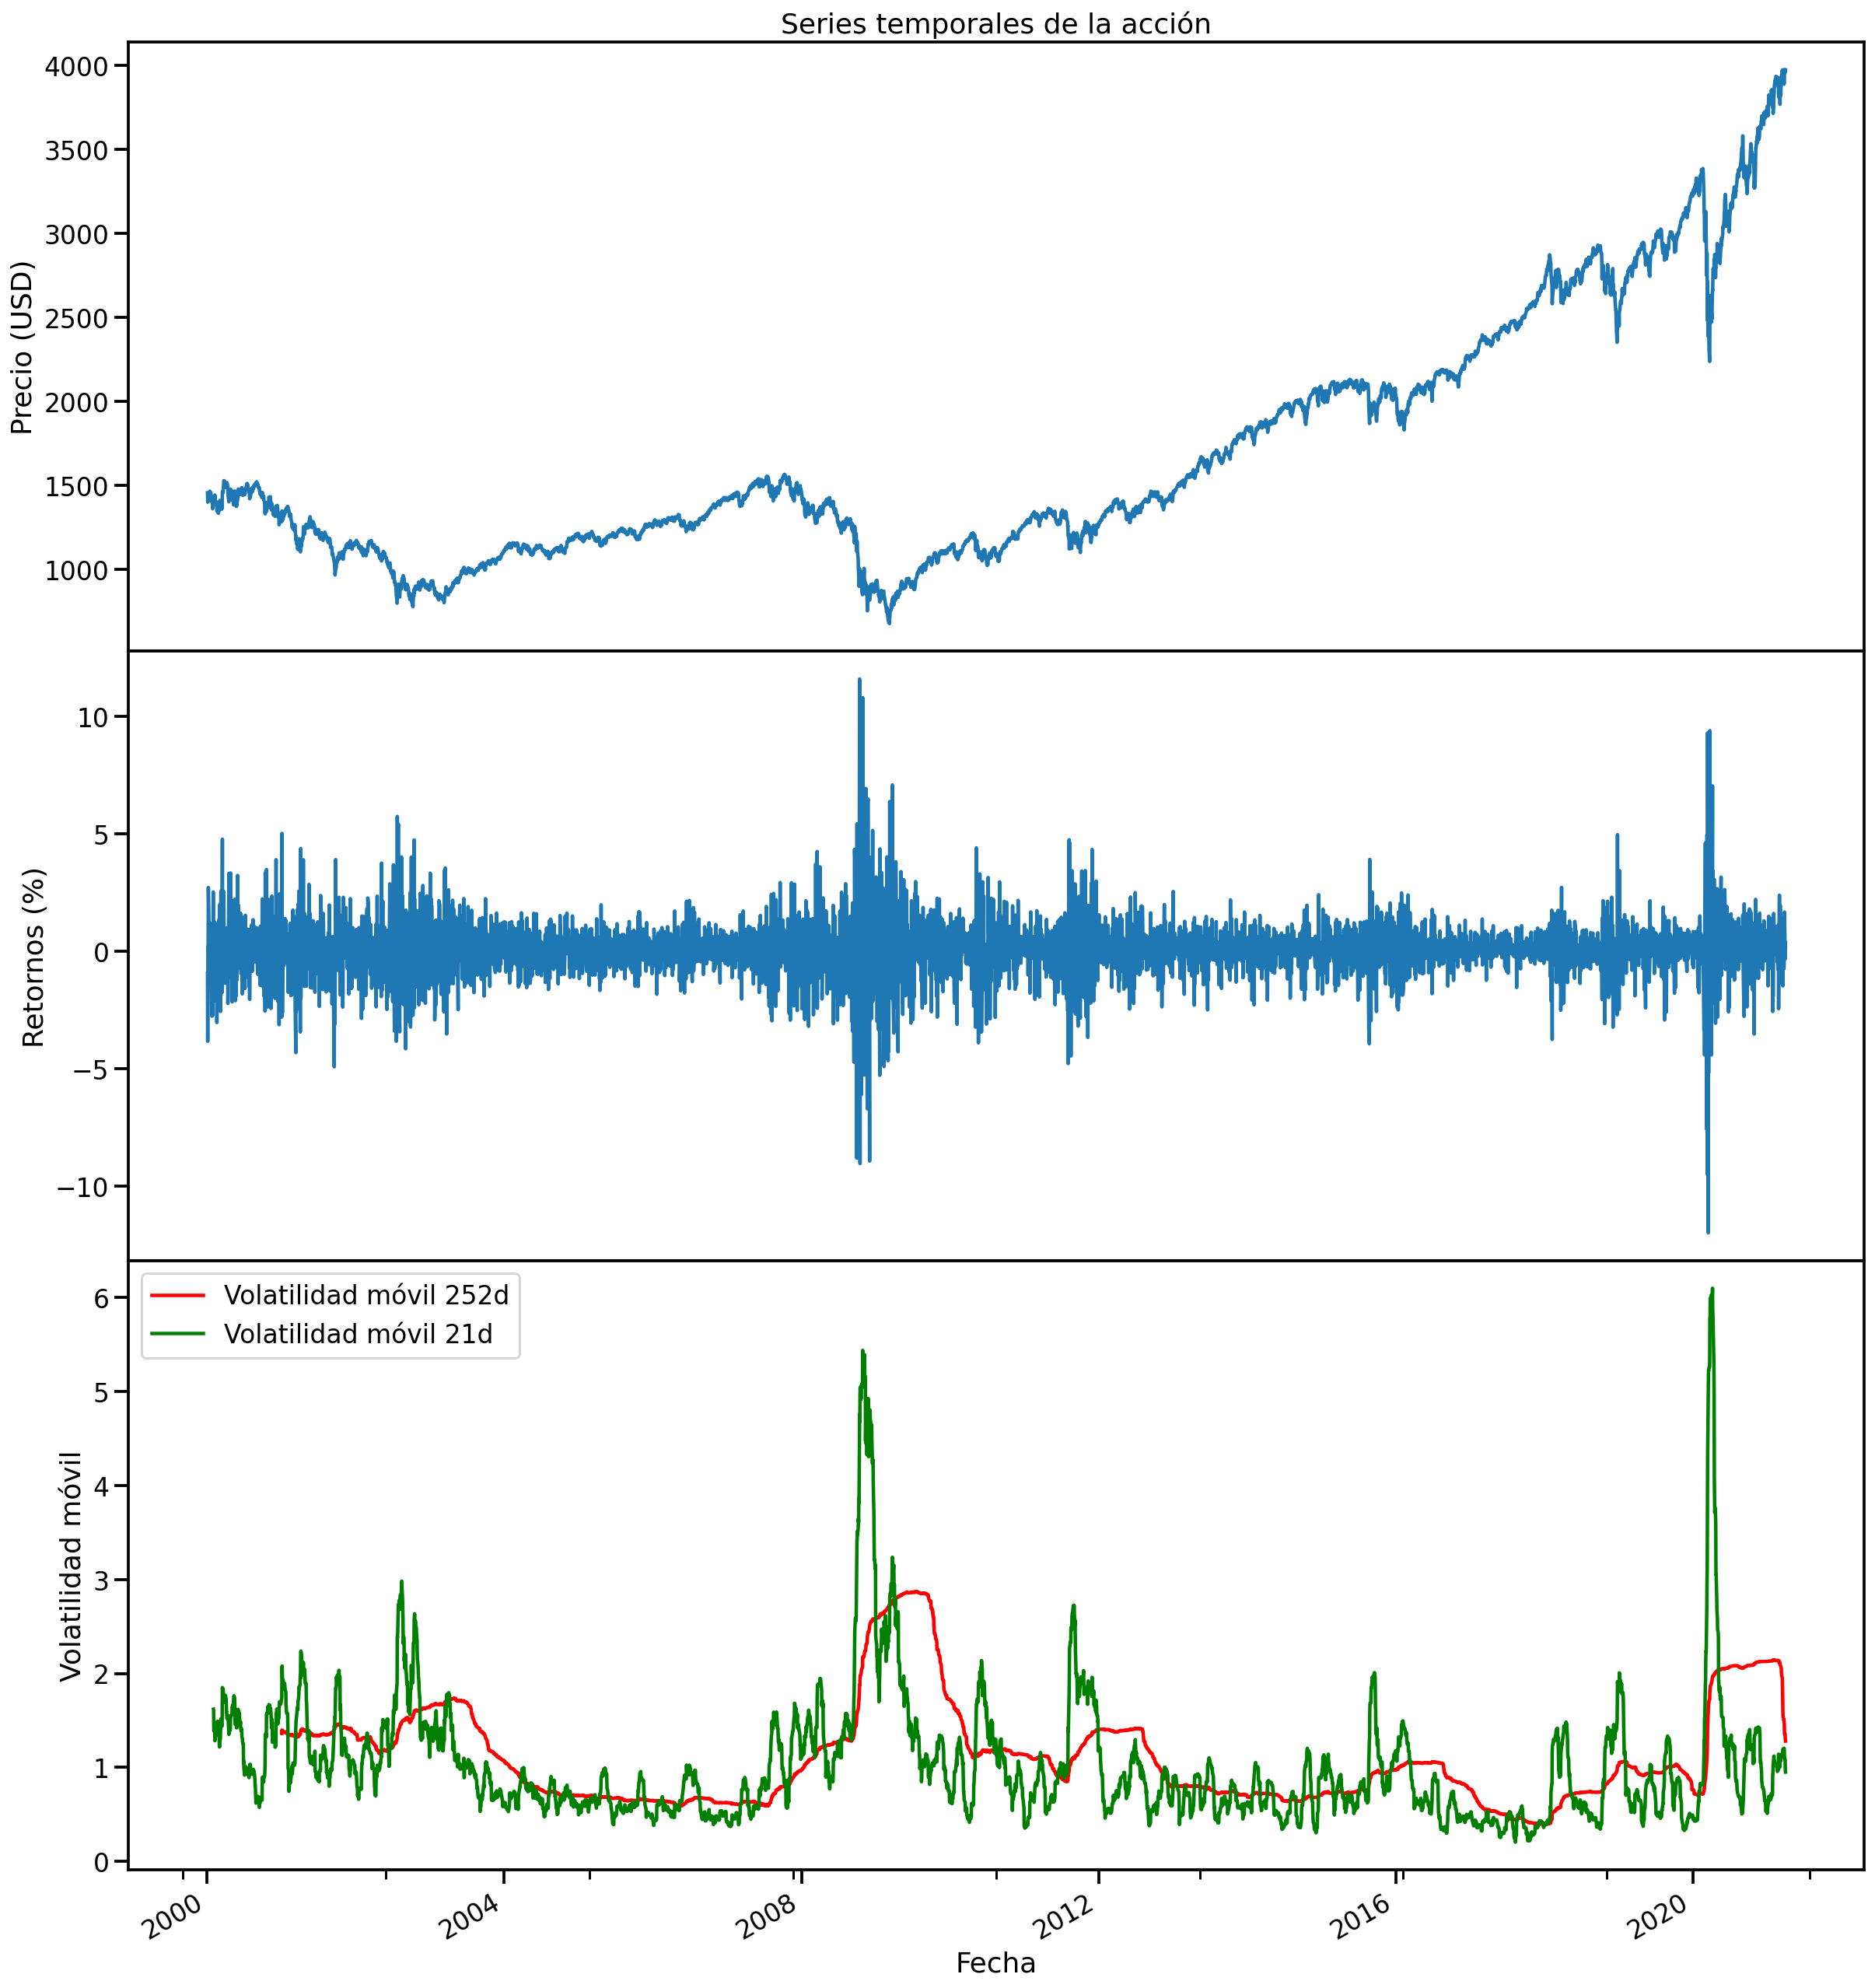

In [14]:
# calcular las desviaciones típicas móviles de los periodos de 252 y 21 días
moving_std_252 = stock_prices.returns.rolling(window=252).std()
moving_std_21 = stock_prices.returns.rolling(window=21).std()

# se dibujan 3 plots
fig, ax = plt.subplots(3, 1, figsize=(20, 24), sharex=True)

# plot de la serie del precio
stock_prices.close.plot(ax=ax[0])
ax[0].set(title='Series temporales de la acción', ylabel='Precio (USD)')

# plot de los retornos
stock_prices.returns.plot(ax=ax[1])
ax[1].set(ylabel='Retornos (%)')

# plot de las desviaciones típicas
moving_std_252.plot(ax=ax[2], color='r', label='Volatilidad móvil 252d')
moving_std_21.plot(ax=ax[2], color='g', label='Volatilidad móvil 21d')
ax[2].set(ylabel='Volatilidad móvil', xlabel='Fecha')
ax[2].legend()

plt.subplots_adjust(hspace = 0)
save_fig('figure_1_7', tight_layout=False)
plt.show()

### Hecho #6: No estacionalidad

In [15]:
# se realiza el test de Dickey Fuller para comprobar la estacionalidad
adf = smt.stattools.adfuller(stock_prices.close)

print('------- Estadísticas de la prueba de Dickey Fuller -------')
print('Prueba T: ', adf[0])
print('Valor p: ', adf[1])
print('Valores críticos: ', adf[4])

------- Estadísticas de la prueba de Dickey Fuller -------
Prueba T:  2.0064151053939208
Valor p:  0.9986812291677737
Valores críticos:  {'1%': -3.4315844283014365, '5%': -2.8620854906213857, '10%': -2.5670603641509433}


## 2.4. Obtención y estudio variable alcista/bajista

In [16]:
# obtener variable que indica si el precio ha subido o bajado
stock_prices['bullish'] = data_preparation.get_bullish(stock_prices.returns)

relative_frecuency = stock_prices.bullish.value_counts() / len(stock_prices.bullish)

bullish_returns = stock_prices.loc[stock_prices.bullish == 1, 'returns']
bearish_returns = stock_prices.loc[stock_prices.bullish == 0, 'returns']


# estadísticas de los retornos en alcista y bajista
print('---------- Estadísticas Descriptivas ----------')
print('Tendencia Alcista:')
print('\t Número de observaciones:', bullish_returns.shape[0])
print(f'\t Frecuencia Relativa: {relative_frecuency[1]:.2%}')
print(f'\t Media: {bullish_returns.mean():.4f}%')
print(f'\t Mediana: {bullish_returns.median():.4}%')
print(f'\t Máximo: {bullish_returns.max():.4f}%')
print(f'\t Desviación éstandar: {bullish_returns.std():.4f}%')

print('Tendencia Bajista:')
print('\t Número de observaciones:', bearish_returns.shape[0])
print(f'\t Frecuencia Relativa: {relative_frecuency[0]:.2%}')
print(f'\t Media: {bearish_returns.mean():.4f}%')
print(f'\t Mediana: {bearish_returns.median():.4f}%')
print(f'\t Mínimo: {bearish_returns.min():.4f}%')
print(f'\t Desviación estándar: {bearish_returns.std():.4f}%')

---------- Estadísticas Descriptivas ----------
Tendencia Alcista:
	 Número de observaciones: 2871
	 Frecuencia Relativa: 53.89%
	 Media: 0.7831%
	 Mediana: 0.5316%
	 Máximo: 11.5800%
	 Desviación éstandar: 0.9015%
Tendencia Bajista:
	 Número de observaciones: 2457
	 Frecuencia Relativa: 46.11%
	 Media: -0.8399%
	 Mediana: -0.5467%
	 Mínimo: -11.9841%
	 Desviación estándar: 0.9707%


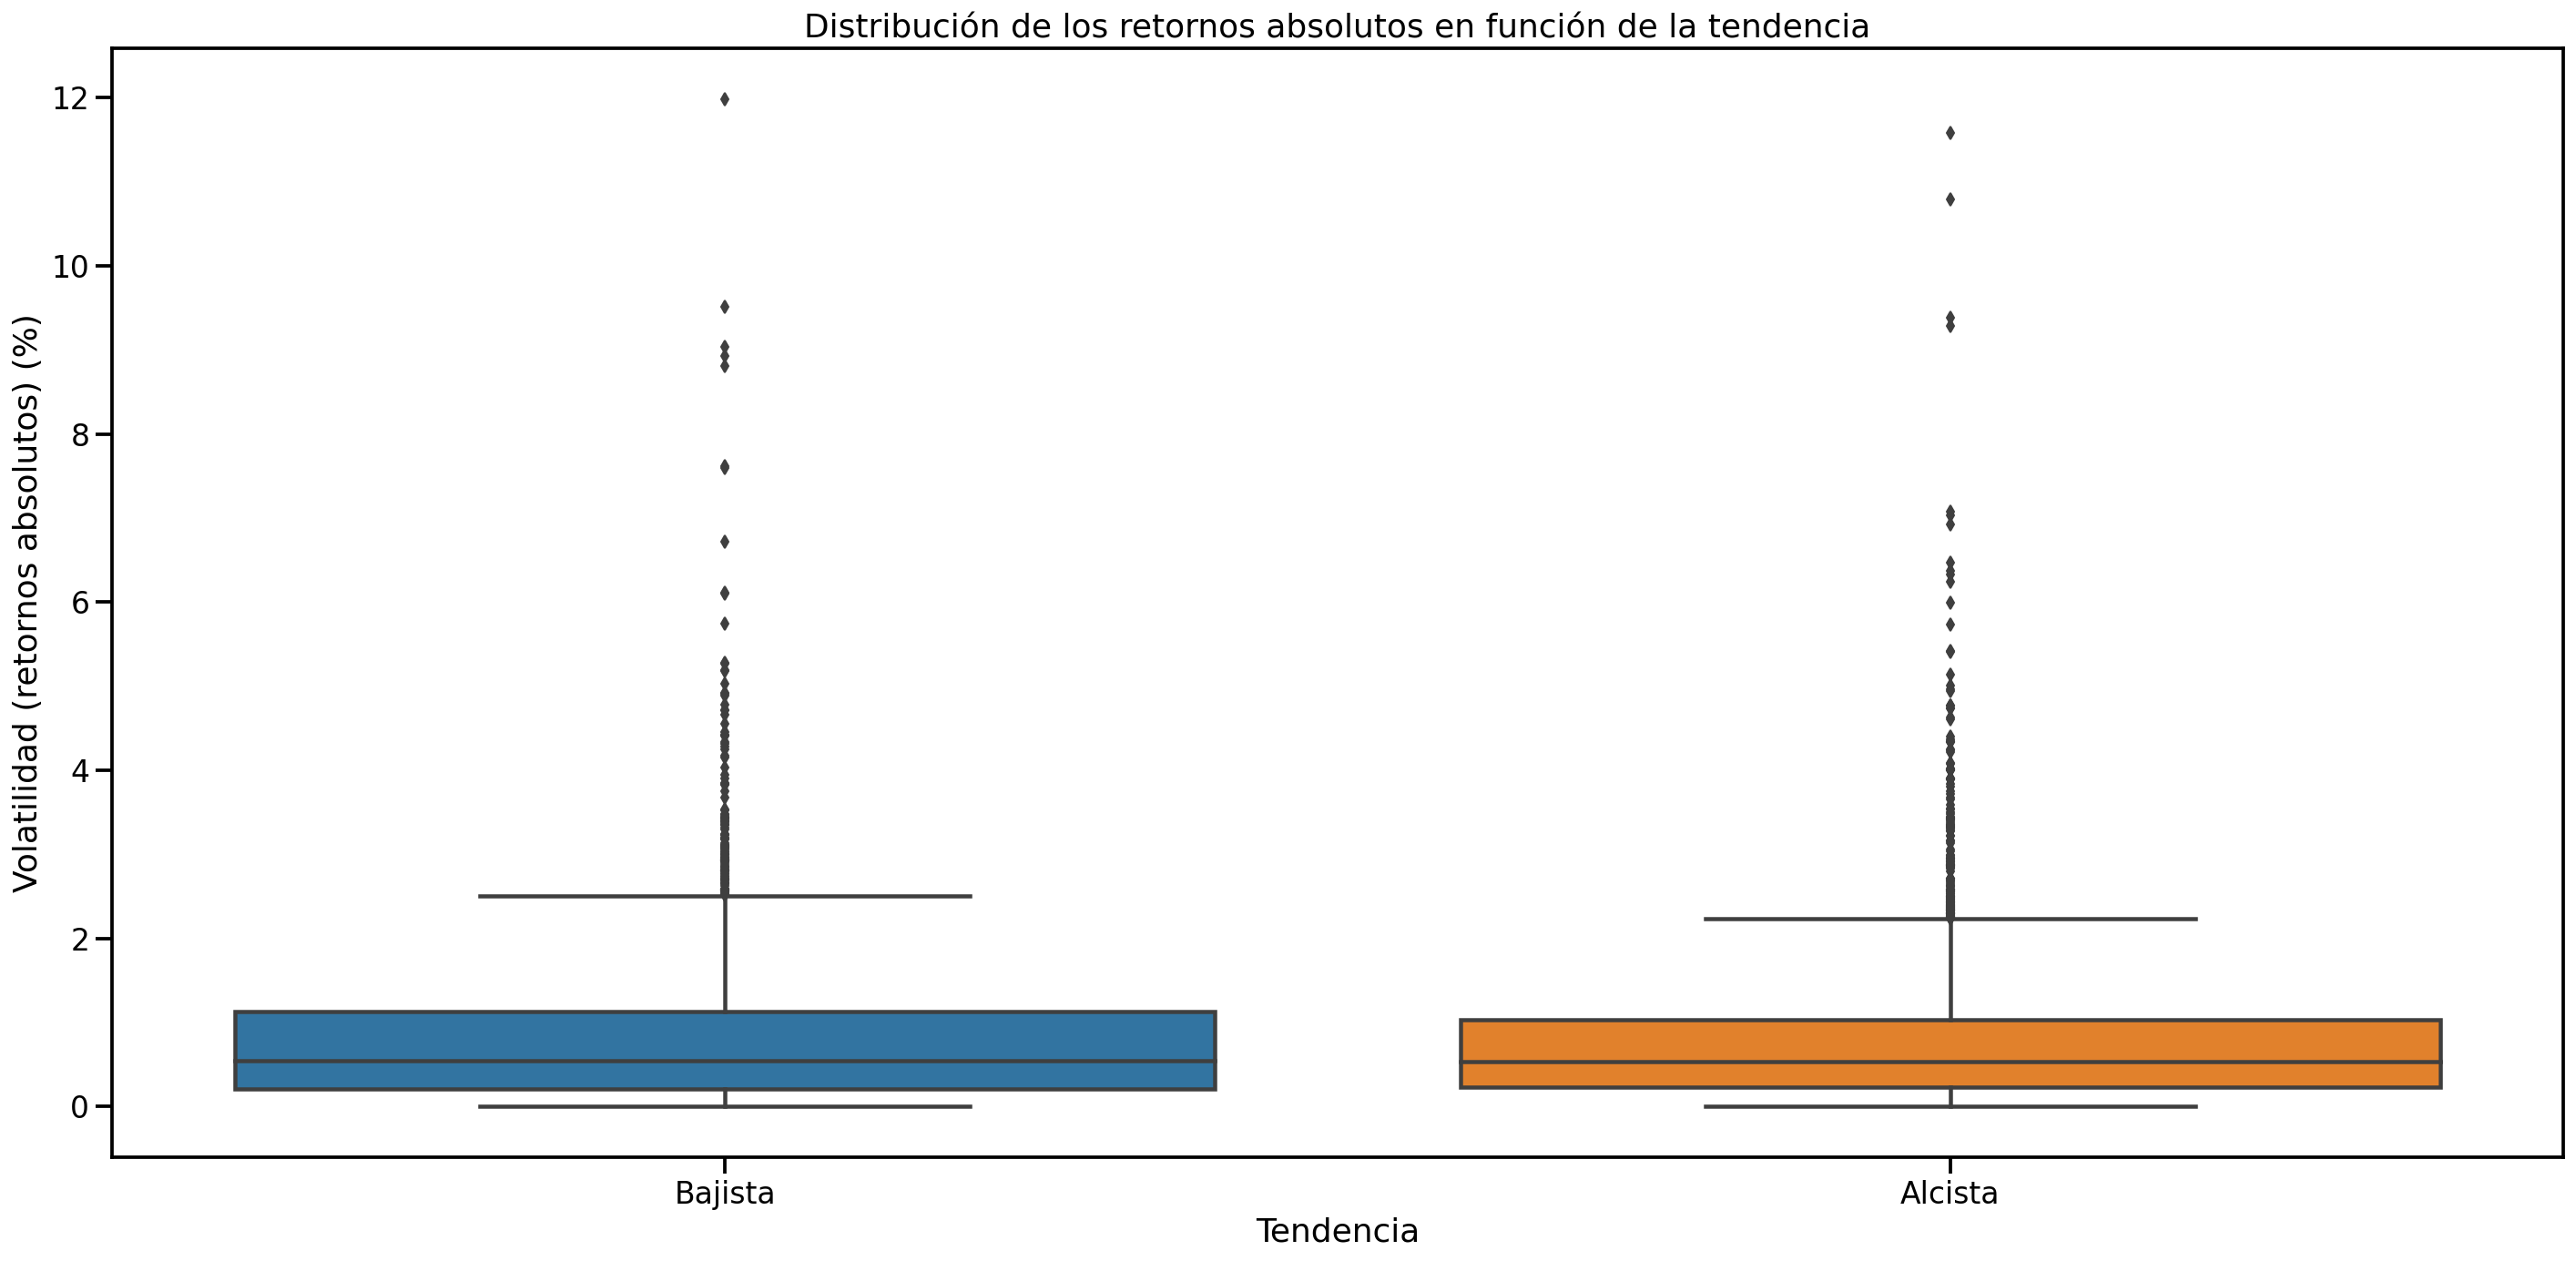

In [17]:
plt.figure(figsize=(20, 10))

# gráfica de la distribución en caja
sns.boxplot(x='bullish', y=np.abs(stock_prices.returns), data=stock_prices)
plt.ylabel('Volatilidad (retornos absolutos) (%)')
plt.xlabel('Tendencia')
plt.xticks([0, 1], ['Bajista', 'Alcista'])
plt.title('Distribución de los retornos absolutos en función de la tendencia')

save_fig('figure_1_8')
plt.show()

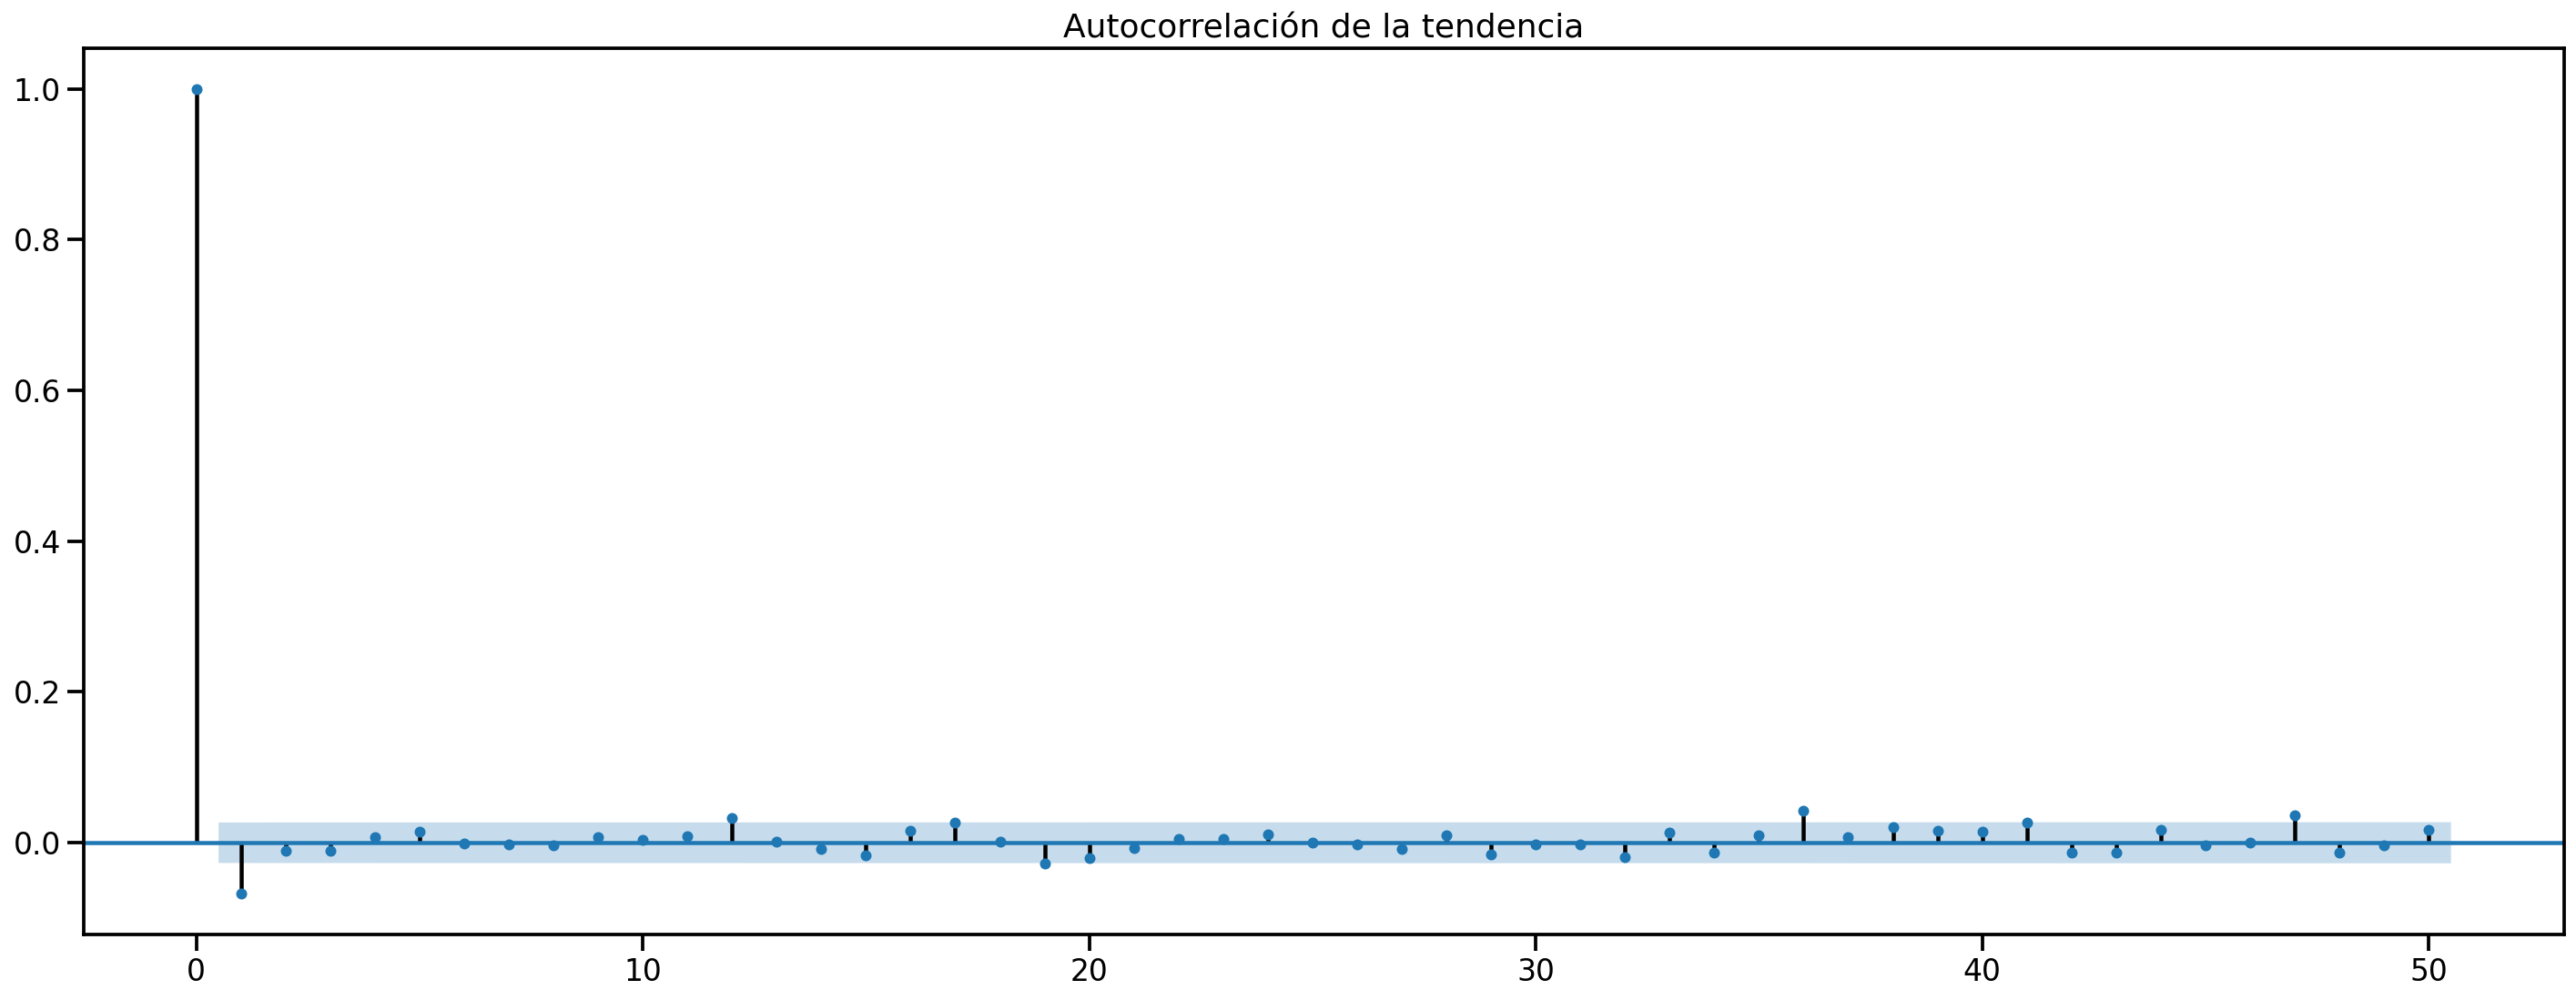

In [18]:
# plot de correlación de la tendencia
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(figsize=(20, 8))
acf = smt.graphics.plot_acf(stock_prices.bullish, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax)
plt.title('Autocorrelación de la tendencia')

save_fig('figure_1_9')
plt.show()

In [24]:
# hypothesis testing: La distribución de los retornos alcistas es igual al de los retornos absolutos bajistas
mw_test = scs.mannwhitneyu(stock_prices.loc[stock_prices.bullish == 1, 'returns'], np.abs(stock_prices.loc[stock_prices.bullish == 0, 'returns']))
print(f'Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')

Estadístico de la prueba Mann-Whitney U: 3476081.00 con valor p: 0.18


## 2.5. Obtención y estudio variable de posicición

In [20]:
# obtener variable que indica la posición que debería haberse tomado
stock_prices['position'] = data_preparation.get_position(stock_prices.returns)

relative_frecuency = stock_prices.position.value_counts() / len(stock_prices.position)

long_returns = stock_prices.loc[stock_prices.position == 1, 'returns']
short_returns = stock_prices.loc[stock_prices.position == 0, 'returns']


# estadísticas de los retornos en long (1) y short (2)
print('---------- Estadísticas descriptivas ----------')
print('Posición larga:')
print('\t Número de observaciones:', long_returns.shape[0])
print(f'\t Frecuencia relativa: {relative_frecuency[1]:.2%}')
print(f'\t Media: {long_returns.mean():.4f}%')
print(f'\t Mediana: {long_returns.median():.4}%')
print(f'\t Máximo: {long_returns.max():.4f}%')
print(f'\t Dseviación estándar: {long_returns.std():.4f}%')

print('Posición corta:')
print('\t Número de observaciones:', short_returns.shape[0])
print(f'\t Frecuencia relativa: {relative_frecuency[0]:.2%}')
print(f'\t Media: {short_returns.mean():.4f}%')
print(f'\t Mediana: {short_returns.median():.4f}%')
print(f'\t Mínimo: {short_returns.min():.4f}%')
print(f'\t Desviación estándar: {short_returns.std():.4f}%')

---------- Estadísticas descriptivas ----------
Posición larga:
	 Número de observaciones: 967
	 Frecuencia relativa: 18.15%
	 Media: 1.6458%
	 Mediana: 1.305%
	 Máximo: 11.5800%
	 Dseviación estándar: 1.0903%
Posición corta:
	 Número de observaciones: 900
	 Frecuencia relativa: 16.89%
	 Media: -1.7353%
	 Mediana: -1.4191%
	 Mínimo: -11.9841%
	 Desviación estándar: 1.1047%


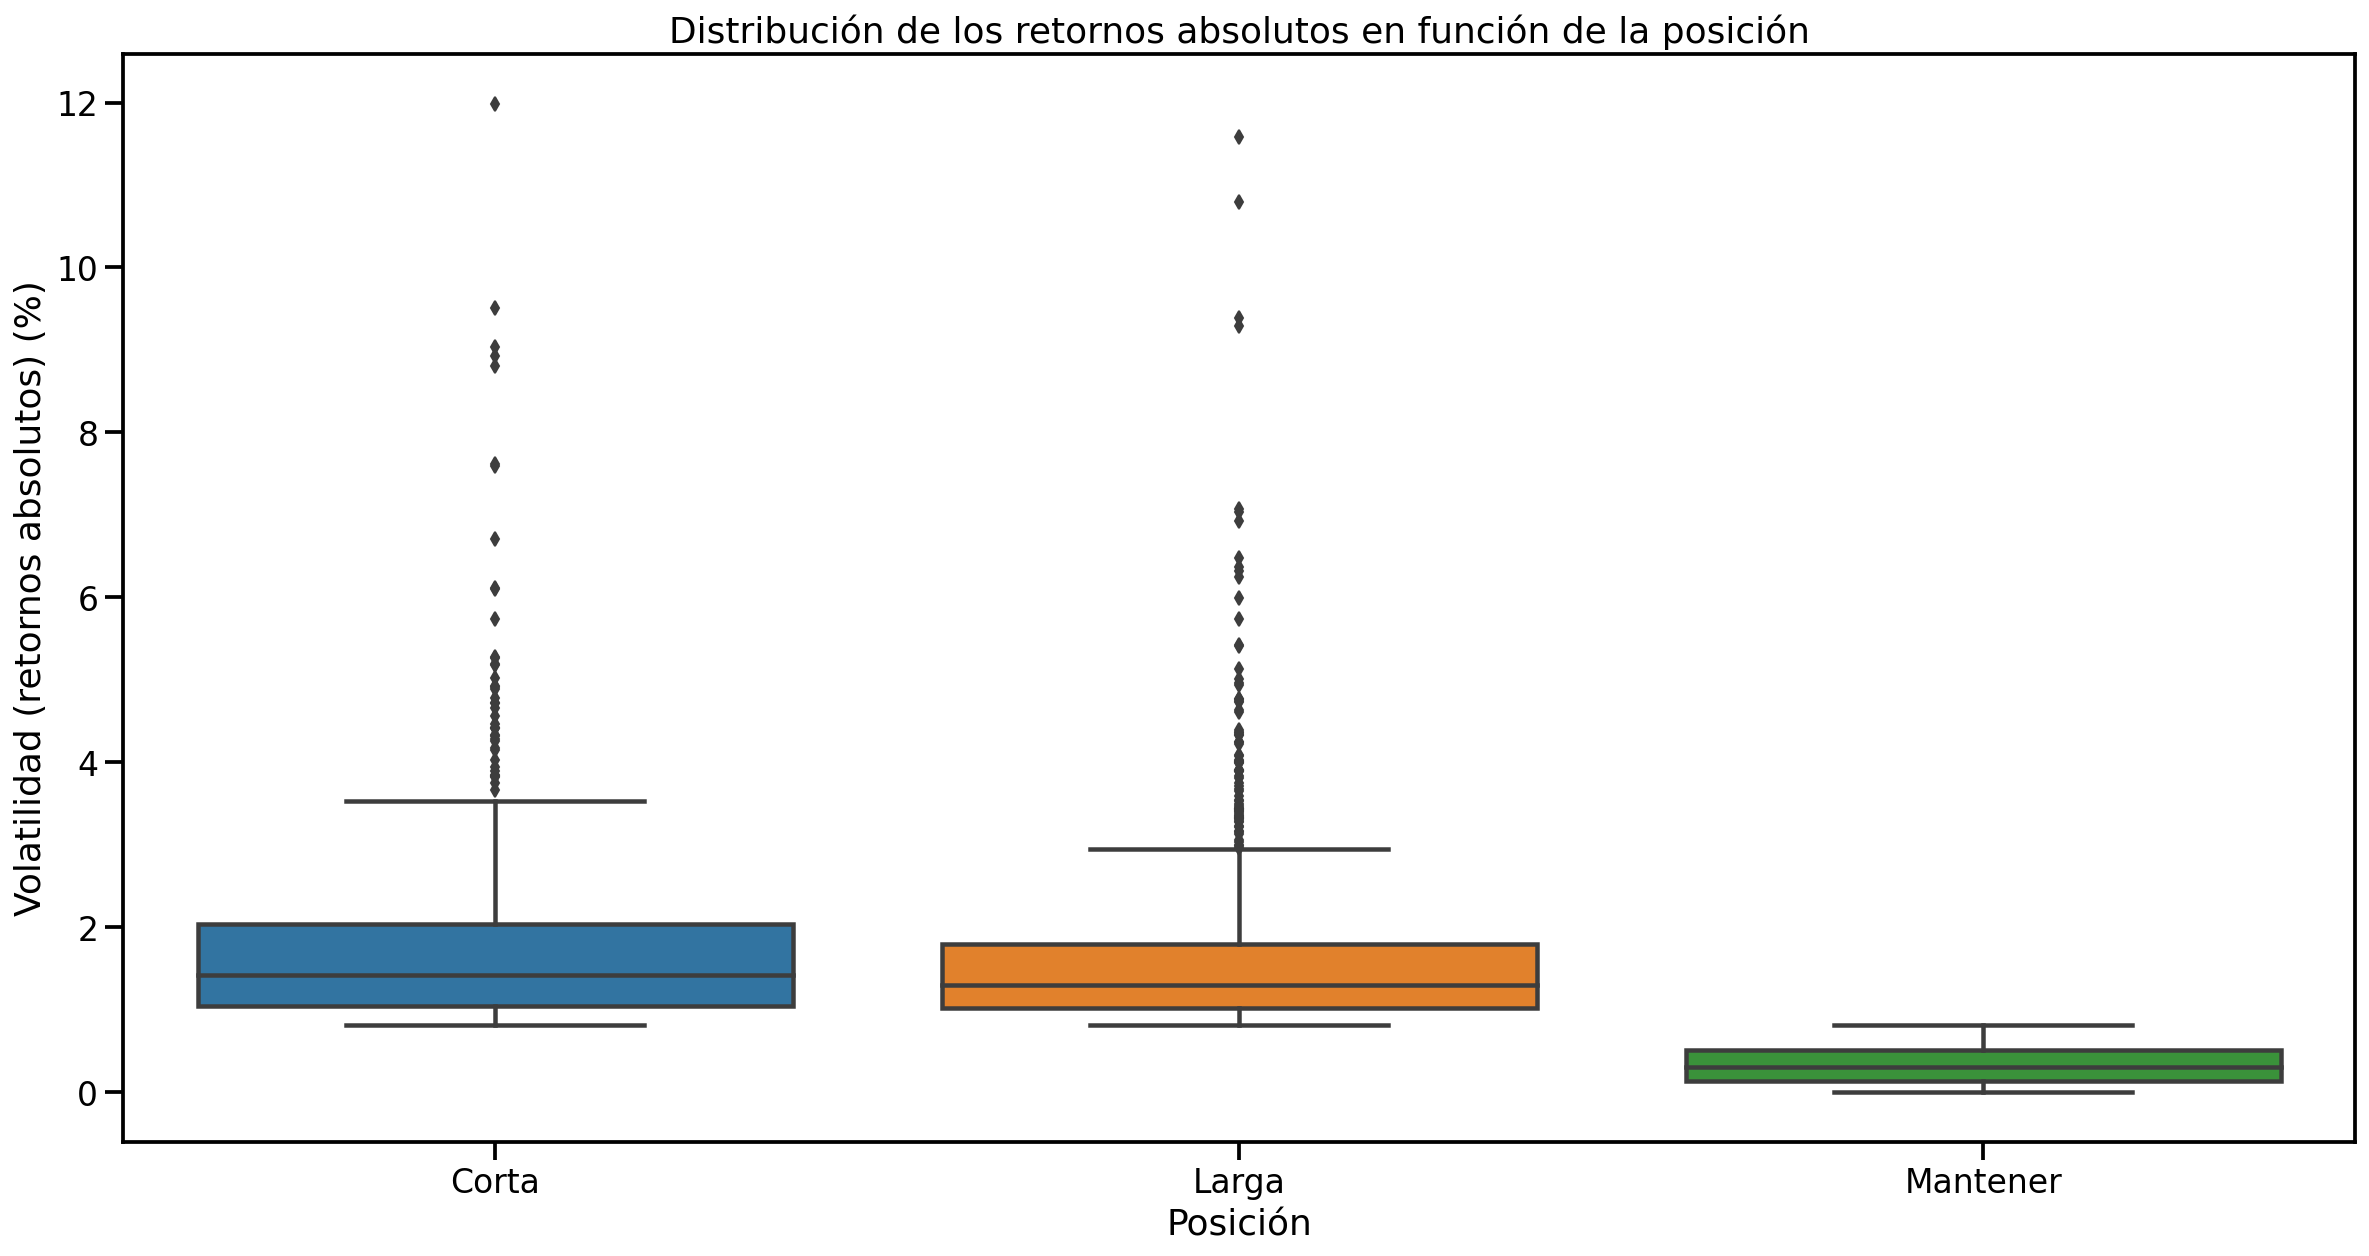

In [21]:
plt.figure(figsize=(20, 10))

# gráfica de la distribución en caja
sns.boxplot(x='position', y=np.abs(stock_prices.returns), data=stock_prices)
plt.ylabel('Volatilidad (retornos absolutos) (%)')
plt.xlabel('Posición')
plt.xticks([0, 1, 2], ['Corta', 'Larga', 'Mantener'])
plt.title('Distribución de los retornos absolutos en función de la posición')

save_fig('figure_1_10', tight_layout=False)
plt.show()

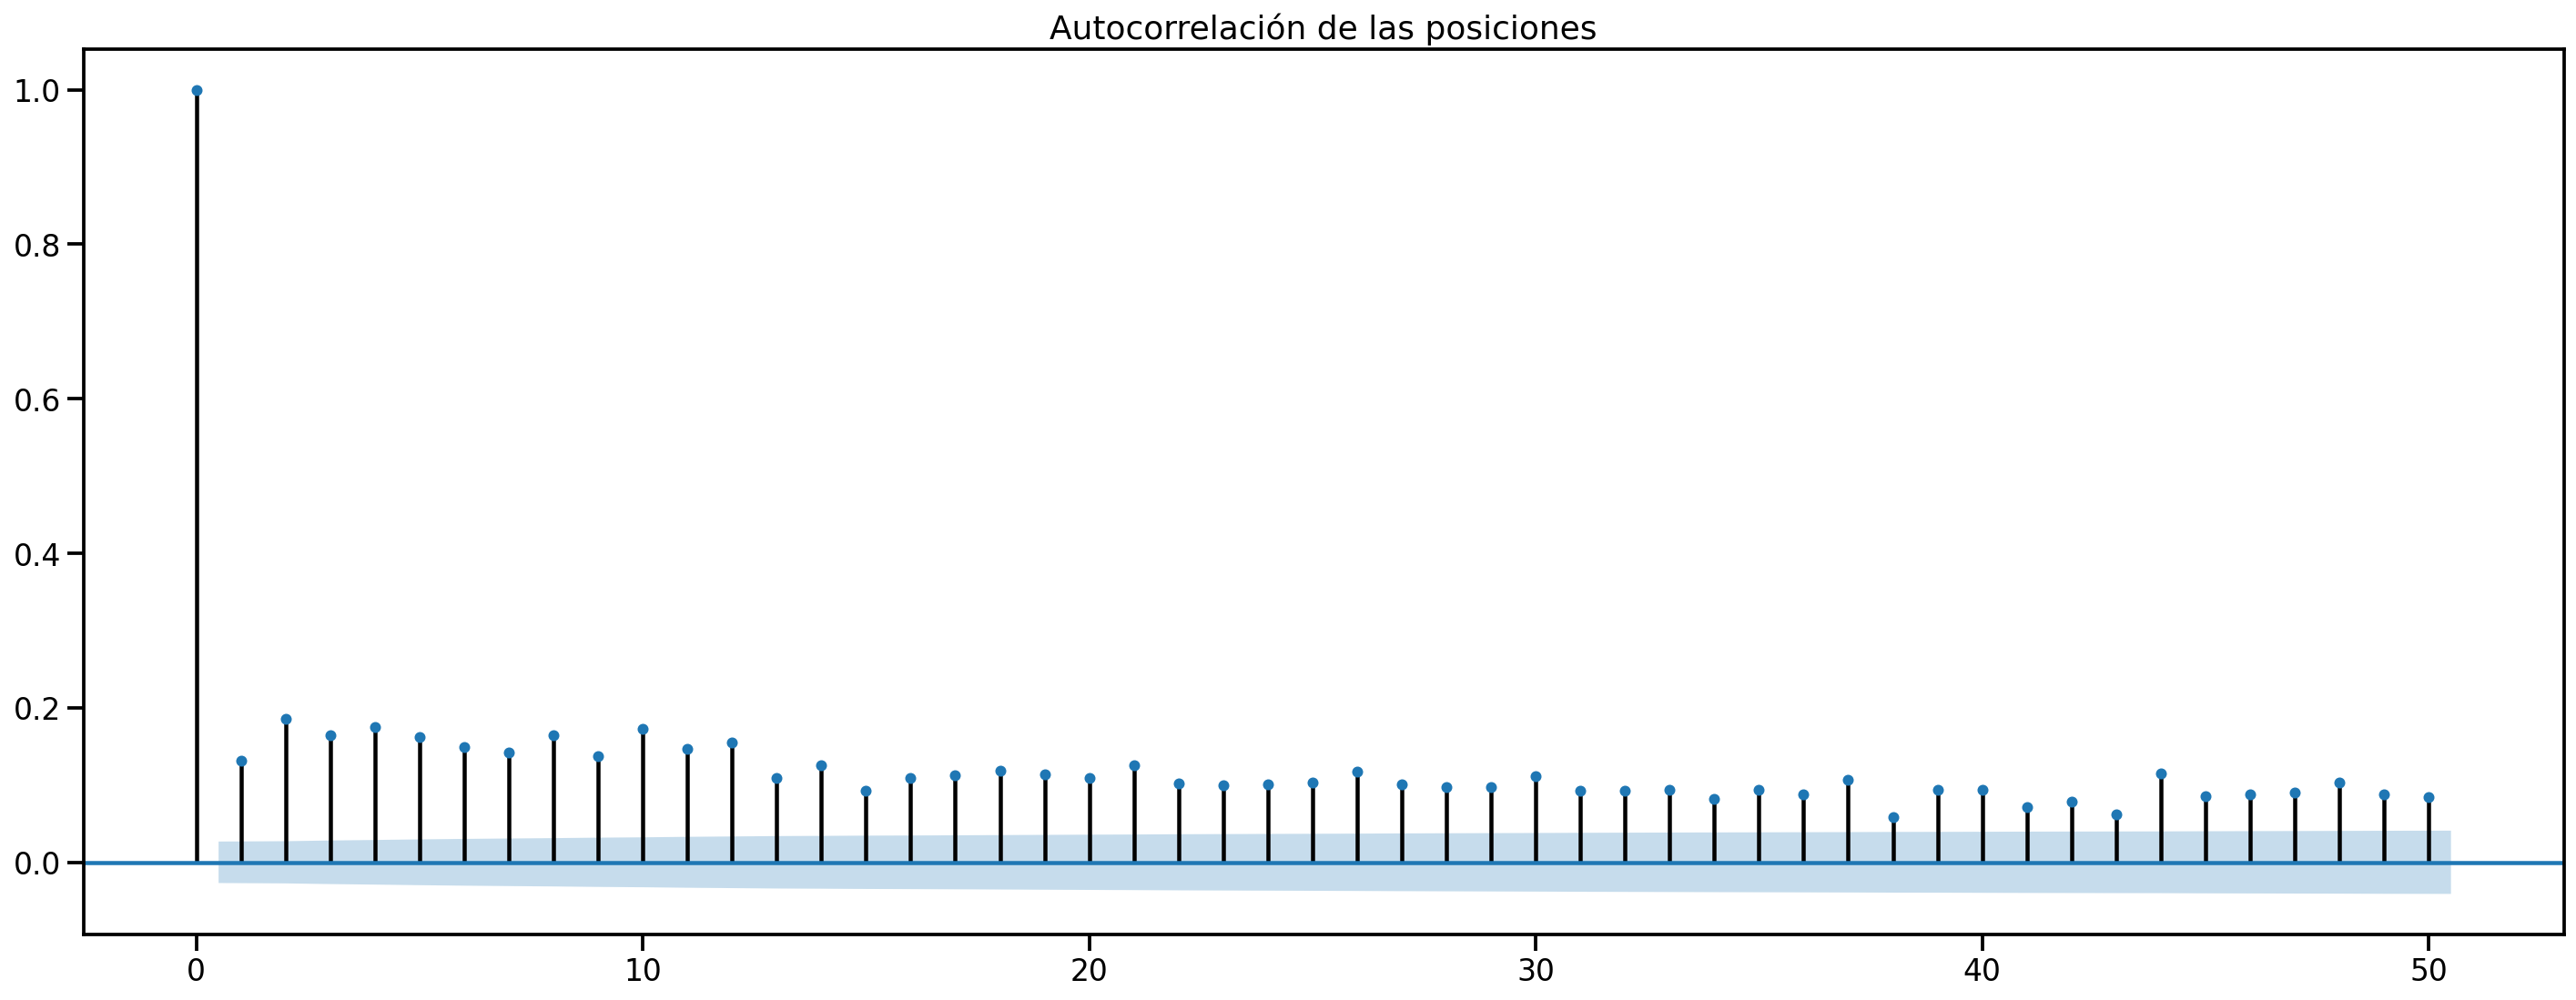

In [22]:
# plot de autocorrelación de la posicion
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(figsize=(20, 8))
acf = smt.graphics.plot_acf(stock_prices.position, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax)
plt.title('Autocorrelación de las posiciones')

save_fig('figure_1_11')
plt.show()

In [25]:
# hypothesis testing: La distribución de los retornos en long es igual al de los retornos absolutos en short
mw_test = scs.mannwhitneyu(stock_prices.loc[stock_prices.position == 1, 'returns'], np.abs(stock_prices.loc[stock_prices.position == 0, 'returns']))
print(f'Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')

Estadístico de la prueba Mann-Whitney U: 402816.00 con valor p: 0.00
